# Pole Compilation

In [1]:
# standard modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
pd.set_option('display.max_rows',500)
pd.set_option('display.max_columns',500)

# pmagpy
import pmagpy.ipmag as ipmag
import pmagpy.pmag as pmag

Functions:

In [2]:
def plot_dates(zircon_means, zircon_2sigmas, include, sample_means, sample_2sigmas, colours, labels,\
               legend=True, figsize=None, ylim=None, lineweight=None, bbox_to_anchor=None, mean_box=None):
    """
    Make a date distribution plot.
    
    Parameters
    ----------
    zircon_means : list of numpy arrays
        individual zircon mean dates (each array being a sample, and each element of that array being a zircon)
    
    zircon_2sigmas : list of numpy arrays
        individual zircon 2 sigmas (each array being a sample, and each element of that array being a zircon)
        
    include : list of lists
        'yes' or 'no' for inclusion of individual zircon in mean (each array being a sample, and each element of
        that array being a zircon)
        
    sample_means : list
        sample mean dates (each element being a sample)
        
    sample_2sigmas : list
        sample 2 sigmas (each element being a sample)
        
    colours : list
        sample colours for plotting (each element being a sample)
        
    labels : list
        sample labels for the legend (each element being a sample)
        
    legend : boolean
        if True, plot legend (default True, optional)
        
    figsize : tuple
        figure size (default None, optional)
        
    ylim : tuple
        figure y limits (default None, optional)
        
    lineweight : float
        line weight for individual zircons (default None, optional)
        
    bbox_to_anchor : tuple
        for manual placement of the legend (default None, optional)
        
    mean_box : list
        booleans, for decided whether to draw the mean and 2 sigma for a sample (default None, optional)
        
    Returns
    -------
    fig : figure handle
    
    ax : axis handle
    """
    # formatting constants
    zircon_spacing = 1
    sample_spacing = 6 - zircon_spacing
    start_x = 3
    yes_alpha = 0.8
    no_alpha = 0.2
    if lineweight==None:
        lineweight=3
    
    # initialize current x
    current_x = start_x
    
    # number of samples
    n_samples = len(zircon_means)
    
    # plot
    if figsize == None:
        fig, ax = plt.subplots()
    else:
        fig, ax = plt.subplots(figsize=figsize)
    
    # iterate over each sample
    plot_mean_box = False
    for i in range(n_samples):
        
        # number of zircons in sample
        n_zircons = len(zircon_means[i])
        
        # check if we need to plot the mean box
        if mean_box==None:
            plot_mean_box = True
        elif mean_box[i]:
            plot_mean_box = True
        
        # iterate over each zircon to find the mean box coordinates
        if plot_mean_box:
            start_box = False
            end_box = False
            for j in range(n_zircons):
                if include[i][j] == 'yes' and start_box == False:
                    start_box_x = current_x + j*zircon_spacing - zircon_spacing/2
                    start_box = True
                if include[i][j] == 'no' and start_box == True and end_box == False:
                    end_box_x = current_x + (j-1)*zircon_spacing + zircon_spacing/2
                    end_box = True
            if end_box == False:
                end_box_x = current_x + (n_zircons-1)*zircon_spacing + zircon_spacing/2

            # plot the mean box
            # the 2sigma uncertainty on the sample age
            if sample_2sigmas != None:
                rectangle = matplotlib.patches.Rectangle((start_box_x, sample_means[i]-sample_2sigmas[i]),
                                                         (end_box_x-start_box_x), sample_2sigmas[i]*2, color='C7')
                ax.add_patch(rectangle)

            # the mean age
            if sample_means != None:
                ax.hlines(sample_means[i], start_box_x, end_box_x)
        
        # iterate over each zircon to plot the zircons
        marked = False # legend control
        for j in range(n_zircons):
            
            if marked:
                if include[i][j] == 'yes':
                    ax.vlines(current_x,
                              zircon_means[i][j]-zircon_2sigmas[i][j],
                              zircon_means[i][j]+zircon_2sigmas[i][j],
                              colors=colours[i], lw=lineweight, alpha=yes_alpha)
                else:
                    ax.vlines(current_x,
                              zircon_means[i][j]-zircon_2sigmas[i][j],
                              zircon_means[i][j]+zircon_2sigmas[i][j],
                              colors=colours[i], lw=lineweight, alpha=no_alpha)
            else:
                if include[i][j] == 'yes':
                    ax.vlines(current_x,
                              zircon_means[i][j]-zircon_2sigmas[i][j],
                              zircon_means[i][j]+zircon_2sigmas[i][j],
                              colors=colours[i], lw=lineweight, alpha=yes_alpha, label=labels[i])
                    marked = True
                else:
                    ax.vlines(current_x,
                              zircon_means[i][j]-zircon_2sigmas[i][j],
                              zircon_means[i][j]+zircon_2sigmas[i][j],
                              colors=colours[i], lw=lineweight, alpha=no_alpha)
                
            # tick the x to the next zircon
            current_x = current_x + zircon_spacing
        
        # tick the x to the next sample
        current_x = current_x + sample_spacing
        
    # prettify
    ax.invert_yaxis()
    ax.set_ylabel('$^{206}$Pb/$^{238}$U date [Ma]')
    if legend:
        if bbox_to_anchor == None:
            ax.legend(bbox_to_anchor=(1.8,1), fontsize=12)
        else:
            ax.legend(bbox_to_anchor=bbox_to_anchor, fontsize=12)
    if ylim != None:
        ax.set_ylim(ylim)
        
    return fig, ax

## South China

Set up compilation dataframe:

In [3]:
compiled_cols = ['age',
                 'age upper (reported)',
                 'age lower (reported)',
                 'age upper (estimate)',
                 'age lower (estimate)',
                 'lat',
                 'lon',
                 'a95',
                 'rock',
                 'f',
                 'slat',
                 'slon',
                 'dec',
                 'inc',
                 'dir_a95',
                 'pole reference',
                 'age reference',
                 'grade',
                 'note']

SChina_compiled = pd.DataFrame(columns=compiled_cols)

j = 0

### Yanbian Dikes

The individual zircon measurements from Table 1 in Niu et al. (2016), dike 09YBD03:

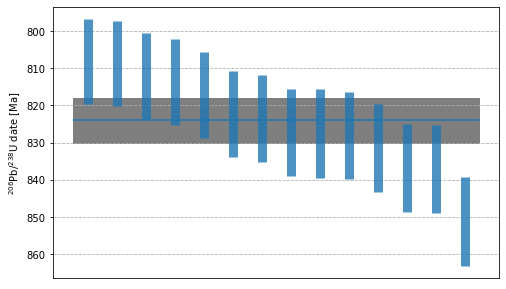

In [4]:
Yanbian_means = np.array([813.7,808.7,831.5,823.6,817.1,827.3,822.3,836.8,828.1,827.5,812.1,851.2,808.1,837.2])
Yanbian_1sigmas = np.array([11.5,11.4,11.8,11.7,11.6,11.7,11.6,11.8,11.7,11.9,11.6,12.0,11.4,11.8])
Yanbian_include = [['yes'] * len(Yanbian_means)]
Yanbian_sample_mean = [824]
Yanbian_sample_1sigma = [6]
Yanbian_colors = ['C0']
Yanbian_labels = ['Yanbian Dike 09YBD03']

# sort
Yanbian_means_argsort = np.argsort(Yanbian_means)
Yanbian_means = [Yanbian_means[Yanbian_means_argsort]]
Yanbian_1sigmas = [Yanbian_1sigmas[Yanbian_means_argsort]]

fig, ax = plot_dates(Yanbian_means,
                     Yanbian_1sigmas,
                     Yanbian_include,
                     Yanbian_sample_mean,
                     Yanbian_sample_1sigma,
                     Yanbian_colors,
                     Yanbian_labels,
                     legend=False, lineweight=9, figsize=(8,5), mean_box=[True])
ax.set_xticks([])
ax.grid(axis='y', ls='--')
plt.show(fig)

In [5]:
SChina_compiled.loc[j, 'age'] = 824
SChina_compiled.loc[j, 'age upper (reported)'] = 824 - 6
SChina_compiled.loc[j, 'age lower (reported)'] = 824 + 6
SChina_compiled.loc[j, 'age upper (estimate)'] = 800
SChina_compiled.loc[j, 'age lower (estimate)'] = 860
SChina_compiled.loc[j, 'lat'] = 45.1
SChina_compiled.loc[j, 'lon'] = 130.4
SChina_compiled.loc[j, 'a95'] = 19.0
SChina_compiled.loc[j, 'rock'] = 'Yanbian Dikes Group A - mafic dikes'
SChina_compiled.loc[j, 'f'] = 1
SChina_compiled.loc[j, 'slat'] = 26.886
SChina_compiled.loc[j, 'slon'] = 101.546
SChina_compiled.loc[j, 'dec'] = np.nan
SChina_compiled.loc[j, 'inc'] = np.nan
SChina_compiled.loc[j, 'dir_a95'] = np.nan
SChina_compiled.loc[j, 'pole reference'] = 'Niu et al. (2016)'
SChina_compiled.loc[j, 'age reference'] = 'Niu et al. (2016) - SIMS on dike'
SChina_compiled.loc[j, 'grade'] = 'B - baked contact test, dike-tilt test, rock magnetism'
SChina_compiled.loc[j, 'note'] = 'A 5 degree vertical axis rotation is applied to these data in the paper. They are not tilt-corrected (except for one) although they are located within a mobile belt.'
j = j + 1

### Madiyi Formation

The individual zircon measurements from Table S1 in Xian et al. (2020), tuff ZJ-B:

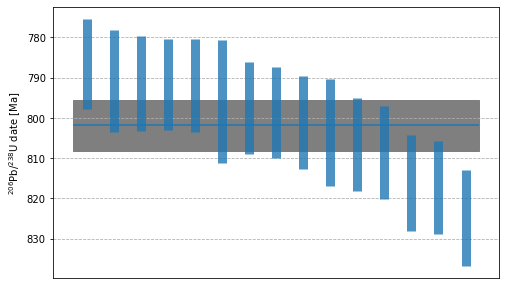

In [6]:
Madiyi_means = np.array([806.6,791.5,797.6,824.9,791.9,817.3,816.2,803.6,786.6,801.2,798.7,808.6,791.7,795.9,790.8])
Madiyi_1sigmas = np.array([11.5,11.8,11.5,11.9,11.5,11.6,11.9,13.3,11.2,11.6,11.3,11.6,11.2,15.2,12.7])
Madiyi_include = [['yes'] * len(Madiyi_means)]
Madiyi_sample_mean = [801.9]
Madiyi_sample_1sigma = [6.3]
Madiyi_colors = ['C0']
Madiyi_labels = ['Madiyi Formation tuff ZJ-B']

# sort
Madiyi_means_argsort = np.argsort(Madiyi_means)
Madiyi_means = [Madiyi_means[Madiyi_means_argsort]]
Madiyi_1sigmas = [Madiyi_1sigmas[Madiyi_means_argsort]]

fig, ax = plot_dates(Madiyi_means,
                     Madiyi_1sigmas,
                     Madiyi_include,
                     Madiyi_sample_mean,
                     Madiyi_sample_1sigma,
                     Madiyi_colors,
                     Madiyi_labels,
                     legend=False, lineweight=9, figsize=(8,5), mean_box=[True])
ax.set_xticks([])
ax.grid(axis='y', ls='--')
plt.show(fig)

In [7]:
SChina_compiled.loc[j, 'age'] = 804.90
SChina_compiled.loc[j, 'age upper (reported)'] = 804.90 - 0.36
SChina_compiled.loc[j, 'age lower (reported)'] = 804.90 + 0.36
SChina_compiled.loc[j, 'age upper (estimate)'] = 804.90 - 0.36
SChina_compiled.loc[j, 'age lower (estimate)'] = 804.90 + 0.36
SChina_compiled.loc[j, 'lat'] = 35.3
SChina_compiled.loc[j, 'lon'] = 67.9
SChina_compiled.loc[j, 'a95'] = np.sqrt(4.7*5.5)
SChina_compiled.loc[j, 'rock'] = 'Madiyi Formation - mudstone'
SChina_compiled.loc[j, 'f'] = 1
SChina_compiled.loc[j, 'slat'] = 27.5
SChina_compiled.loc[j, 'slon'] = 109.6
SChina_compiled.loc[j, 'dec'] = 293.1
SChina_compiled.loc[j, 'inc'] = 69.9
SChina_compiled.loc[j, 'dir_a95'] = 3.2
SChina_compiled.loc[j, 'pole reference'] = 'Xian et al. (2020)'
SChina_compiled.loc[j, 'age reference'] = 'this study - CA-ID-TIMS on tuff'
SChina_compiled.loc[j, 'grade'] = 'n/a - reversal test'
SChina_compiled.loc[j, 'note'] = 'Inclination correction preferred by authors.'
j = j + 1

In [8]:
SChina_compiled.loc[j, 'age'] = 804.90
SChina_compiled.loc[j, 'age upper (reported)'] = 804.90 - 0.36
SChina_compiled.loc[j, 'age lower (reported)'] = 804.90 + 0.36
SChina_compiled.loc[j, 'age upper (estimate)'] = 804.90 - 0.36
SChina_compiled.loc[j, 'age lower (estimate)'] = 804.90 + 0.36
SChina_compiled.loc[j, 'lat'] = 34.3
SChina_compiled.loc[j, 'lon'] = 82.4
SChina_compiled.loc[j, 'a95'] = np.sqrt(3.9*3.7)
SChina_compiled.loc[j, 'rock'] = 'Madiyi Formation - mudstone'
SChina_compiled.loc[j, 'f'] = 0.6
SChina_compiled.loc[j, 'slat'] = 27.5
SChina_compiled.loc[j, 'slon'] = 109.6
SChina_compiled.loc[j, 'dec'] = 293.0
SChina_compiled.loc[j, 'inc'] = 77.3
SChina_compiled.loc[j, 'dir_a95'] = 2.1
SChina_compiled.loc[j, 'pole reference'] = 'Xian et al. (2020)'
SChina_compiled.loc[j, 'age reference'] = 'this study - CA-ID-TIMS on tuff'
SChina_compiled.loc[j, 'grade'] = 'n/a - reversal test'
SChina_compiled.loc[j, 'note'] = 'Inclination correction preferred by authors.'
j = j + 1

In [9]:
ipmag.unsquish(69.9,0.6)

77.61614788938651

### Chengjiang Formation

The individual zircon measurements from Table S1 in Jing et al. (2019), tuff LM2Z:

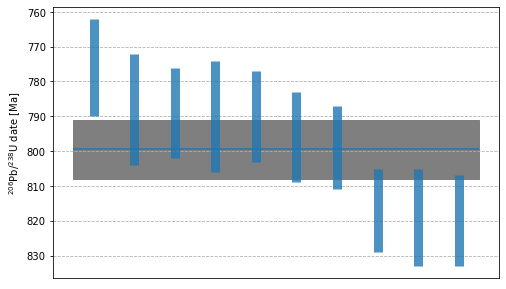

In [10]:
Chengjiang_means = np.array([799,817,790,819,796,788,789,820,790,776])
Chengjiang_1sigmas = np.array([12,12,16,14,13,16,13,13,13,14])
Chengjiang_include = [['yes'] * len(Chengjiang_means)]
Chengjiang_sample_mean = [799.5]
Chengjiang_sample_1sigma = [8.4]
Chengjiang_colors = ['C0']
Chengjiang_labels = ['Chengjiang tuff LM2Z']

# sort
Chengjiang_means_argsort = np.argsort(Chengjiang_means)
Chengjiang_means = [Chengjiang_means[Chengjiang_means_argsort]]
Chengjiang_1sigmas = [Chengjiang_1sigmas[Chengjiang_means_argsort]]

fig, ax = plot_dates(Chengjiang_means,
                     Chengjiang_1sigmas,
                     Chengjiang_include,
                     Chengjiang_sample_mean,
                     Chengjiang_sample_1sigma,
                     Chengjiang_colors,
                     Chengjiang_labels,
                     legend=False, lineweight=9, figsize=(8,5), mean_box=[True])
ax.set_xticks([])
ax.grid(axis='y', ls='--')
plt.show(fig)

The pole that is reported in the abstract of Jing et al. (2019):

In [11]:
SChina_compiled.loc[j, 'age'] = 799.5
SChina_compiled.loc[j, 'age upper (reported)'] = 799.5 - 8.4
SChina_compiled.loc[j, 'age lower (reported)'] = 799.5 + 8.4
SChina_compiled.loc[j, 'age upper (estimate)'] = 770
SChina_compiled.loc[j, 'age lower (estimate)'] = 830
SChina_compiled.loc[j, 'lat'] = 33.4
SChina_compiled.loc[j, 'lon'] = 56.1
SChina_compiled.loc[j, 'a95'] = np.sqrt(7.3*8.9)
SChina_compiled.loc[j, 'rock'] = 'Chengjiang Formation - sandstone'
SChina_compiled.loc[j, 'f'] = 1
SChina_compiled.loc[j, 'slat'] = 25.145
SChina_compiled.loc[j, 'slon'] = 102.411
SChina_compiled.loc[j, 'dec'] = 111.9+180
SChina_compiled.loc[j, 'inc'] = -(-66.7)
SChina_compiled.loc[j, 'dir_a95'] = 5.2
SChina_compiled.loc[j, 'pole reference'] = 'Jing et al. (2019)'
SChina_compiled.loc[j, 'age reference'] = 'Jing et al. (2019) - SIMS on tuffaceous siltstone'
SChina_compiled.loc[j, 'grade'] = 'n/a - fold test, reversal test'
SChina_compiled.loc[j, 'note'] = 'sample mean'
j = j + 1

Calculate an inclination-corrected version of the pole:

In [12]:
Chengjiang_sample_dec = 111.9+180
Chengjiang_sample_inc = -(-66.7)
Chengjiang_sample_a95 = 5.2
Chengjiang_sample_slat = 25.145
Chengjiang_sample_slon = 102.411

Chengjiang_sample_inc_unsquished = ipmag.unsquish([Chengjiang_sample_inc],0.6)[0]

Chengjiang_sample_vgp_unsquished = pmag.dia_vgp(Chengjiang_sample_dec,
                                                Chengjiang_sample_inc_unsquished,
                                                Chengjiang_sample_a95,
                                                Chengjiang_sample_slat,
                                                Chengjiang_sample_slon)

SChina_compiled.loc[j, 'age'] = 799.5
SChina_compiled.loc[j, 'age upper (reported)'] = 799.5 - 8.4
SChina_compiled.loc[j, 'age lower (reported)'] = 799.5 + 8.4
SChina_compiled.loc[j, 'age upper (estimate)'] = 770
SChina_compiled.loc[j, 'age lower (estimate)'] = 830
SChina_compiled.loc[j, 'lat'] = Chengjiang_sample_vgp_unsquished[1]
SChina_compiled.loc[j, 'lon'] = Chengjiang_sample_vgp_unsquished[0]
SChina_compiled.loc[j, 'a95'] = np.sqrt(Chengjiang_sample_vgp_unsquished[2]*Chengjiang_sample_vgp_unsquished[3])
SChina_compiled.loc[j, 'rock'] = 'Chengjiang Formation - sandstone'
SChina_compiled.loc[j, 'f'] = 0.6
SChina_compiled.loc[j, 'slat'] = 25.145
SChina_compiled.loc[j, 'slon'] = 102.411
SChina_compiled.loc[j, 'dec'] = 111.9+180
SChina_compiled.loc[j, 'inc'] = Chengjiang_sample_inc_unsquished
SChina_compiled.loc[j, 'dir_a95'] = 5.2
SChina_compiled.loc[j, 'pole reference'] = 'Jing et al. (2019)'
SChina_compiled.loc[j, 'age reference'] = 'Jing et al. (2019) - SIMS on tuffaceous siltstone'
SChina_compiled.loc[j, 'grade'] = 'n/a - fold test, reversal test'
SChina_compiled.loc[j, 'note'] = 'sample mean'
j = j + 1

Calculate a pole from the sites instead:

In [13]:
Chengjiang_site_dec = 287.0
Chengjiang_site_inc = 69.2
Chengjiang_site_a95 = 6.9
Chengjiang_site_slat = 25.145
Chengjiang_site_slon = 102.411

Chengjiang_site_inc_unsquished = ipmag.unsquish([Chengjiang_site_inc],0.6)[0]

Chengjiang_site_vgp = pmag.dia_vgp(Chengjiang_site_dec,
                                   Chengjiang_site_inc,
                                   Chengjiang_site_a95,
                                   Chengjiang_site_slat,
                                   Chengjiang_site_slon)

Chengjiang_site_vgp_unsquished = pmag.dia_vgp(Chengjiang_site_dec,
                                              Chengjiang_site_inc_unsquished,
                                              Chengjiang_site_a95,
                                              Chengjiang_site_slat,
                                              Chengjiang_site_slon)

SChina_compiled.loc[j, 'age'] = 799.5
SChina_compiled.loc[j, 'age upper (reported)'] = 799.5 - 8.4
SChina_compiled.loc[j, 'age lower (reported)'] = 799.5 + 8.4
SChina_compiled.loc[j, 'age upper (estimate)'] = 770
SChina_compiled.loc[j, 'age lower (estimate)'] = 830
SChina_compiled.loc[j, 'lat'] = Chengjiang_site_vgp[1]
SChina_compiled.loc[j, 'lon'] = Chengjiang_site_vgp[0]
SChina_compiled.loc[j, 'a95'] = np.sqrt(Chengjiang_site_vgp[2]*Chengjiang_site_vgp[3])
SChina_compiled.loc[j, 'rock'] = 'Chengjiang Formation - sandstone'
SChina_compiled.loc[j, 'f'] = 1
SChina_compiled.loc[j, 'slat'] = 25.145
SChina_compiled.loc[j, 'slon'] = 102.411
SChina_compiled.loc[j, 'dec'] = 287.0
SChina_compiled.loc[j, 'inc'] = 69.2
SChina_compiled.loc[j, 'dir_a95'] = 6.9
SChina_compiled.loc[j, 'pole reference'] = 'Jing et al. (2019)'
SChina_compiled.loc[j, 'age reference'] = 'Jing et al. (2019) - SIMS on tuffaceous siltstone'
SChina_compiled.loc[j, 'grade'] = 'n/a - fold test, reversal test'
SChina_compiled.loc[j, 'note'] = 'site mean'
j = j + 1

SChina_compiled.loc[j, 'age'] = 799.5
SChina_compiled.loc[j, 'age upper (reported)'] = 799.5 - 8.4
SChina_compiled.loc[j, 'age lower (reported)'] = 799.5 + 8.4
SChina_compiled.loc[j, 'age upper (estimate)'] = 770
SChina_compiled.loc[j, 'age lower (estimate)'] = 830
SChina_compiled.loc[j, 'lat'] = Chengjiang_site_vgp_unsquished[1]
SChina_compiled.loc[j, 'lon'] = Chengjiang_site_vgp_unsquished[0]
SChina_compiled.loc[j, 'a95'] = np.sqrt(Chengjiang_site_vgp_unsquished[2]*Chengjiang_site_vgp_unsquished[3])
SChina_compiled.loc[j, 'rock'] = 'Chengjiang Formation - sandstone'
SChina_compiled.loc[j, 'f'] = 0.6
SChina_compiled.loc[j, 'slat'] = 25.145
SChina_compiled.loc[j, 'slon'] = 102.411
SChina_compiled.loc[j, 'dec'] = 287.0
SChina_compiled.loc[j, 'inc'] = Chengjiang_site_inc_unsquished
SChina_compiled.loc[j, 'dir_a95'] = 6.9
SChina_compiled.loc[j, 'pole reference'] = 'Jing et al. (2019)'
SChina_compiled.loc[j, 'age reference'] = 'Jing et al. (2019) - SIMS on tuffaceous siltstone'
SChina_compiled.loc[j, 'grade'] = 'n/a - fold test, reversal test'
SChina_compiled.loc[j, 'note'] = 'site mean'
j = j + 1

### Liantuo Formation

Age is preliminary:

Grand mean pole of Evans et al. (2000) and Jing et al. (2015):

In [14]:
SChina_compiled.loc[j, 'age'] = 788
SChina_compiled.loc[j, 'age upper (reported)'] = np.nan
SChina_compiled.loc[j, 'age lower (reported)'] = np.nan
SChina_compiled.loc[j, 'age upper (estimate)'] = np.nan
SChina_compiled.loc[j, 'age lower (estimate)'] = np.nan
SChina_compiled.loc[j, 'lat'] = 13.2
SChina_compiled.loc[j, 'lon'] = 155.2
SChina_compiled.loc[j, 'a95'] = 5.3
SChina_compiled.loc[j, 'rock'] = 'Liantuo Formation grand mean - siltstone-sandstone'
SChina_compiled.loc[j, 'f'] = 1
SChina_compiled.loc[j, 'slat'] = 30.819
SChina_compiled.loc[j, 'slon'] = 111.069
SChina_compiled.loc[j, 'dec'] = np.nan
SChina_compiled.loc[j, 'inc'] = np.nan
SChina_compiled.loc[j, 'dir_a95'] = np.nan
SChina_compiled.loc[j, 'pole reference'] = 'Jing et al. (2015)'
SChina_compiled.loc[j, 'age reference'] = 'redated preliminary results - TIMS on tuff'
SChina_compiled.loc[j, 'grade'] = 'B - reversal test'
SChina_compiled.loc[j, 'note'] = 'Grand mean pole of Evans et al. (2000) and Jing et al. (2015).'
j = j + 1

Just the Jing et al. (2015) pole:

In [15]:
SChina_compiled.loc[j, 'age'] = 788
SChina_compiled.loc[j, 'age upper (reported)'] = np.nan
SChina_compiled.loc[j, 'age lower (reported)'] = np.nan
SChina_compiled.loc[j, 'age upper (estimate)'] = np.nan
SChina_compiled.loc[j, 'age lower (estimate)'] = np.nan
SChina_compiled.loc[j, 'lat'] = 12.7
SChina_compiled.loc[j, 'lon'] = 157.4
SChina_compiled.loc[j, 'a95'] = np.sqrt(4.5*5.8)
SChina_compiled.loc[j, 'rock'] = 'Liantuo Formation - siltstone-sandstone'
SChina_compiled.loc[j, 'f'] = 1
SChina_compiled.loc[j, 'slat'] = 30.819
SChina_compiled.loc[j, 'slon'] = 111.069
SChina_compiled.loc[j, 'dec'] = 102.5
SChina_compiled.loc[j, 'inc'] = 62.4
SChina_compiled.loc[j, 'dir_a95'] = 3.7
SChina_compiled.loc[j, 'pole reference'] = 'Jing et al. (2015)'
SChina_compiled.loc[j, 'age reference'] = 'redated preliminary results - TIMS on tuff'
SChina_compiled.loc[j, 'grade'] = 'B - reversal test'
SChina_compiled.loc[j, 'note'] = 'Just the Jing et al. (2015) pole.'
j = j + 1

Inclination corrected:

In [16]:
Liantuo_site_dec = 102.5
Liantuo_site_inc = 62.4
Liantuo_site_a95 = 3.7
Liantuo_site_slat = 30.819
Liantuo_site_slon = 111.069

Liantuo_site_inc_unsquished = ipmag.unsquish([Liantuo_site_inc],0.6)[0]

Liantuo_site_vgp_unsquished = pmag.dia_vgp(Liantuo_site_dec,
                                           Liantuo_site_inc_unsquished,
                                           Liantuo_site_a95,
                                           Liantuo_site_slat,
                                           Liantuo_site_slon)

SChina_compiled.loc[j, 'age'] = 788
SChina_compiled.loc[j, 'age upper (reported)'] = np.nan
SChina_compiled.loc[j, 'age lower (reported)'] = np.nan
SChina_compiled.loc[j, 'age upper (estimate)'] = np.nan
SChina_compiled.loc[j, 'age lower (estimate)'] = np.nan
SChina_compiled.loc[j, 'lat'] = Liantuo_site_vgp_unsquished[1]
SChina_compiled.loc[j, 'lon'] = Liantuo_site_vgp_unsquished[0]
SChina_compiled.loc[j, 'a95'] = np.sqrt(Liantuo_site_vgp_unsquished[2]*Liantuo_site_vgp_unsquished[3])
SChina_compiled.loc[j, 'rock'] = 'Liantuo Formation - siltstone-sandstone'
SChina_compiled.loc[j, 'f'] = 0.6
SChina_compiled.loc[j, 'slat'] = 30.819
SChina_compiled.loc[j, 'slon'] = 111.069
SChina_compiled.loc[j, 'dec'] = 102.5
SChina_compiled.loc[j, 'inc'] = Liantuo_site_inc_unsquished
SChina_compiled.loc[j, 'dir_a95'] = 3.7
SChina_compiled.loc[j, 'pole reference'] = 'Jing et al. (2015)'
SChina_compiled.loc[j, 'age reference'] = 'redated preliminary results - TIMS on tuff'
SChina_compiled.loc[j, 'grade'] = 'B - reversal test'
SChina_compiled.loc[j, 'note'] = 'Just the Jing et al. (2015) pole.'
j = j + 1

### Banxi Group

These poles are developed in `Banxi_site_analysis.ipynb`.

Age is preliminary.

In [17]:
SChina_compiled.loc[j, 'age'] = 815
SChina_compiled.loc[j, 'age upper (reported)'] = np.nan
SChina_compiled.loc[j, 'age lower (reported)'] = np.nan
SChina_compiled.loc[j, 'age upper (estimate)'] = np.nan
SChina_compiled.loc[j, 'age lower (estimate)'] = np.nan
SChina_compiled.loc[j, 'lat'] = 51.7
SChina_compiled.loc[j, 'lon'] = 99.9
SChina_compiled.loc[j, 'a95'] = np.sqrt(12.0*12.9)
SChina_compiled.loc[j, 'rock'] = 'Banxi Group - siltstone'
SChina_compiled.loc[j, 'f'] = 1
SChina_compiled.loc[j, 'slat'] = 27.95
SChina_compiled.loc[j, 'slon'] = 108.83
SChina_compiled.loc[j, 'dec'] = 166.7+180
SChina_compiled.loc[j, 'inc'] = -(-77.0)
SChina_compiled.loc[j, 'dir_a95'] = 6.9
SChina_compiled.loc[j, 'pole reference'] = 'preliminary results'
SChina_compiled.loc[j, 'age reference'] = 'preliminary results - TIMS on tuff'
SChina_compiled.loc[j, 'grade'] = 'n/a - fold test, reversal test'
SChina_compiled.loc[j, 'note'] = 'site mean'
j = j + 1

In [18]:
SChina_compiled.loc[j, 'age'] = 815
SChina_compiled.loc[j, 'age upper (reported)'] = np.nan
SChina_compiled.loc[j, 'age lower (reported)'] = np.nan
SChina_compiled.loc[j, 'age upper (estimate)'] = np.nan
SChina_compiled.loc[j, 'age lower (estimate)'] = np.nan
SChina_compiled.loc[j, 'lat'] = 42.9
SChina_compiled.loc[j, 'lon'] = 104.0
SChina_compiled.loc[j, 'a95'] = np.sqrt(13.1*13.5)
SChina_compiled.loc[j, 'rock'] = 'Banxi Group - siltstone'
SChina_compiled.loc[j, 'f'] = 0.6
SChina_compiled.loc[j, 'slat'] = 27.95
SChina_compiled.loc[j, 'slon'] = 108.83
SChina_compiled.loc[j, 'dec'] = 166.7+180
SChina_compiled.loc[j, 'inc'] = ipmag.unsquish(-(-77.0),0.6)
SChina_compiled.loc[j, 'dir_a95'] = 6.9
SChina_compiled.loc[j, 'pole reference'] = 'preliminary results'
SChina_compiled.loc[j, 'age reference'] = 'preliminary results - TIMS on tuff'
SChina_compiled.loc[j, 'grade'] = 'n/a - fold test, reversal test'
SChina_compiled.loc[j, 'note'] = 'site mean'
j = j + 1

In [19]:
SChina_compiled.loc[j, 'age'] = 815
SChina_compiled.loc[j, 'age upper (reported)'] = np.nan
SChina_compiled.loc[j, 'age lower (reported)'] = np.nan
SChina_compiled.loc[j, 'age upper (estimate)'] = np.nan
SChina_compiled.loc[j, 'age lower (estimate)'] = np.nan
SChina_compiled.loc[j, 'lat'] = 53.1
SChina_compiled.loc[j, 'lon'] = 107.6
SChina_compiled.loc[j, 'a95'] = np.sqrt(7.4*7.9)
SChina_compiled.loc[j, 'rock'] = 'Banxi Group - siltstone'
SChina_compiled.loc[j, 'f'] = 1
SChina_compiled.loc[j, 'slat'] = 27.95
SChina_compiled.loc[j, 'slon'] = 108.83
SChina_compiled.loc[j, 'dec'] = 178.3+180
SChina_compiled.loc[j, 'inc'] = -(-76.8)
SChina_compiled.loc[j, 'dir_a95'] = 4.3
SChina_compiled.loc[j, 'pole reference'] = 'preliminary results'
SChina_compiled.loc[j, 'age reference'] = 'preliminary results - TIMS on tuff'
SChina_compiled.loc[j, 'grade'] = 'n/a - fold test, reversal test'
SChina_compiled.loc[j, 'note'] = 'sample mean'
j = j + 1

In [20]:
SChina_compiled.loc[j, 'age'] = 815
SChina_compiled.loc[j, 'age upper (reported)'] = np.nan
SChina_compiled.loc[j, 'age lower (reported)'] = np.nan
SChina_compiled.loc[j, 'age upper (estimate)'] = np.nan
SChina_compiled.loc[j, 'age lower (estimate)'] = np.nan
SChina_compiled.loc[j, 'lat'] = 43.7
SChina_compiled.loc[j, 'lon'] = 108.2
SChina_compiled.loc[j, 'a95'] = np.sqrt(8.1*8.3)
SChina_compiled.loc[j, 'rock'] = 'Banxi Group - siltstone'
SChina_compiled.loc[j, 'f'] = 0.6
SChina_compiled.loc[j, 'slat'] = 27.95
SChina_compiled.loc[j, 'slon'] = 108.83
SChina_compiled.loc[j, 'dec'] = 178.3+180
SChina_compiled.loc[j, 'inc'] = ipmag.unsquish(-(-76.8),0.6)
SChina_compiled.loc[j, 'dir_a95'] = 4.3
SChina_compiled.loc[j, 'pole reference'] = 'preliminary results'
SChina_compiled.loc[j, 'age reference'] = 'preliminary results - TIMS on tuff'
SChina_compiled.loc[j, 'grade'] = 'n/a - fold test, reversal test'
SChina_compiled.loc[j, 'note'] = 'sample mean'
j = j + 1

In [21]:
SChina_compiled.loc[j, 'age'] = 815
SChina_compiled.loc[j, 'age upper (reported)'] = np.nan
SChina_compiled.loc[j, 'age lower (reported)'] = np.nan
SChina_compiled.loc[j, 'age upper (estimate)'] = np.nan
SChina_compiled.loc[j, 'age lower (estimate)'] = np.nan
SChina_compiled.loc[j, 'lat'] = -(-73.0)
SChina_compiled.loc[j, 'lon'] = 58.4+180
SChina_compiled.loc[j, 'a95'] = np.sqrt(5.1*9.2)
SChina_compiled.loc[j, 'rock'] = 'Banxi Group TR001 and TR002'
SChina_compiled.loc[j, 'f'] = 1
SChina_compiled.loc[j, 'slat'] = 27.95
SChina_compiled.loc[j, 'slon'] = 108.83
SChina_compiled.loc[j, 'dec'] = 13.6
SChina_compiled.loc[j, 'inc'] = 30.6
SChina_compiled.loc[j, 'dir_a95'] = 8.3
SChina_compiled.loc[j, 'pole reference'] = 'preliminary results'
SChina_compiled.loc[j, 'age reference'] = 'preliminary results - TIMS on tuff'
SChina_compiled.loc[j, 'grade'] = 'n/a - fold test, reversal test'
SChina_compiled.loc[j, 'note'] = 'TR001 and TR002 samples only'
j = j + 1

In [22]:
SChina_compiled.loc[j, 'age'] = 815
SChina_compiled.loc[j, 'age upper (reported)'] = np.nan
SChina_compiled.loc[j, 'age lower (reported)'] = np.nan
SChina_compiled.loc[j, 'age upper (estimate)'] = np.nan
SChina_compiled.loc[j, 'age lower (estimate)'] = np.nan
SChina_compiled.loc[j, 'lat'] = -(-77.8)
SChina_compiled.loc[j, 'lon'] = 23.7+180
SChina_compiled.loc[j, 'a95'] = np.sqrt(6.6*10.4)
SChina_compiled.loc[j, 'rock'] = 'Banxi Group TR001 and TR002'
SChina_compiled.loc[j, 'f'] = 0.6
SChina_compiled.loc[j, 'slat'] = 27.95
SChina_compiled.loc[j, 'slon'] = 108.83
SChina_compiled.loc[j, 'dec'] = 13.6
SChina_compiled.loc[j, 'inc'] = ipmag.unsquish(30.6,0.6)
SChina_compiled.loc[j, 'dir_a95'] = 8.3
SChina_compiled.loc[j, 'pole reference'] = 'preliminary results'
SChina_compiled.loc[j, 'age reference'] = 'preliminary results - TIMS on tuff'
SChina_compiled.loc[j, 'grade'] = 'n/a - fold test, reversal test'
SChina_compiled.loc[j, 'note'] = 'TR001 and TR002 samples only'
j = j + 1

In [23]:
SChina_compiled.loc[j, 'age'] = 815
SChina_compiled.loc[j, 'age upper (reported)'] = np.nan
SChina_compiled.loc[j, 'age lower (reported)'] = np.nan
SChina_compiled.loc[j, 'age upper (estimate)'] = np.nan
SChina_compiled.loc[j, 'age lower (estimate)'] = np.nan
SChina_compiled.loc[j, 'lat'] = 46.5
SChina_compiled.loc[j, 'lon'] = 112.0
SChina_compiled.loc[j, 'a95'] = np.sqrt(12.3*12.8)
SChina_compiled.loc[j, 'rock'] = 'Banxi Group Luoman'
SChina_compiled.loc[j, 'f'] = 1
SChina_compiled.loc[j, 'slat'] = 27.95
SChina_compiled.loc[j, 'slon'] = 108.83
SChina_compiled.loc[j, 'dec'] = 186.9-180
SChina_compiled.loc[j, 'inc'] = -(-80.4)
SChina_compiled.loc[j, 'dir_a95'] = 6.6
SChina_compiled.loc[j, 'pole reference'] = 'preliminary results'
SChina_compiled.loc[j, 'age reference'] = 'preliminary results - TIMS on tuff'
SChina_compiled.loc[j, 'grade'] = 'n/a - fold test, reversal test'
SChina_compiled.loc[j, 'note'] = 'Luoman samples only'
j = j + 1

In [24]:
SChina_compiled.loc[j, 'age'] = 815
SChina_compiled.loc[j, 'age upper (reported)'] = np.nan
SChina_compiled.loc[j, 'age lower (reported)'] = np.nan
SChina_compiled.loc[j, 'age upper (estimate)'] = np.nan
SChina_compiled.loc[j, 'age lower (estimate)'] = np.nan
SChina_compiled.loc[j, 'lat'] = 39.4
SChina_compiled.loc[j, 'lon'] = 110.6
SChina_compiled.loc[j, 'a95'] = np.sqrt(12.9*13.1)
SChina_compiled.loc[j, 'rock'] = 'Banxi Group Luoman'
SChina_compiled.loc[j, 'f'] = 0.6
SChina_compiled.loc[j, 'slat'] = 27.95
SChina_compiled.loc[j, 'slon'] = 108.83
SChina_compiled.loc[j, 'dec'] = 186.9-180
SChina_compiled.loc[j, 'inc'] = ipmag.unsquish(-(-80.4),0.6)
SChina_compiled.loc[j, 'dir_a95'] = 6.6
SChina_compiled.loc[j, 'pole reference'] = 'preliminary results'
SChina_compiled.loc[j, 'age reference'] = 'preliminary results - TIMS on tuff'
SChina_compiled.loc[j, 'grade'] = 'n/a - fold test, reversal test'
SChina_compiled.loc[j, 'note'] = 'Luoman samples only'
j = j + 1

In [25]:
SChina_compiled.loc[j, 'age'] = 815
SChina_compiled.loc[j, 'age upper (reported)'] = np.nan
SChina_compiled.loc[j, 'age lower (reported)'] = np.nan
SChina_compiled.loc[j, 'age upper (estimate)'] = np.nan
SChina_compiled.loc[j, 'age lower (estimate)'] = np.nan
SChina_compiled.loc[j, 'lat'] = 48.8
SChina_compiled.loc[j, 'lon'] = 81.1
SChina_compiled.loc[j, 'a95'] = np.sqrt(11.4*12.7)
SChina_compiled.loc[j, 'rock'] = 'Banxi Group TR004'
SChina_compiled.loc[j, 'f'] = 1
SChina_compiled.loc[j, 'slat'] = 27.95
SChina_compiled.loc[j, 'slon'] = 108.83
SChina_compiled.loc[j, 'dec'] = 141.9+180
SChina_compiled.loc[j, 'inc'] = -(-74.0)
SChina_compiled.loc[j, 'dir_a95'] = 7.0
SChina_compiled.loc[j, 'pole reference'] = 'preliminary results'
SChina_compiled.loc[j, 'age reference'] = 'preliminary results - TIMS on tuff'
SChina_compiled.loc[j, 'grade'] = 'n/a - fold test, reversal test'
SChina_compiled.loc[j, 'note'] = 'TR004 samples only'
j = j + 1

In [26]:
SChina_compiled.loc[j, 'age'] = 815
SChina_compiled.loc[j, 'age upper (reported)'] = np.nan
SChina_compiled.loc[j, 'age lower (reported)'] = np.nan
SChina_compiled.loc[j, 'age upper (estimate)'] = np.nan
SChina_compiled.loc[j, 'age lower (estimate)'] = np.nan
SChina_compiled.loc[j, 'lat'] = 42.0
SChina_compiled.loc[j, 'lon'] = 93.2
SChina_compiled.loc[j, 'a95'] = np.sqrt(12.9*13.5)
SChina_compiled.loc[j, 'rock'] = 'Banxi Group TR004'
SChina_compiled.loc[j, 'f'] = 0.6
SChina_compiled.loc[j, 'slat'] = 27.95
SChina_compiled.loc[j, 'slon'] = 108.83
SChina_compiled.loc[j, 'dec'] = 141.9+180
SChina_compiled.loc[j, 'inc'] = ipmag.unsquish(-(-74.0),0.6)
SChina_compiled.loc[j, 'dir_a95'] = 7.0
SChina_compiled.loc[j, 'pole reference'] = 'preliminary results'
SChina_compiled.loc[j, 'age reference'] = 'preliminary results - TIMS on tuff'
SChina_compiled.loc[j, 'grade'] = 'n/a - fold test, reversal test'
SChina_compiled.loc[j, 'note'] = 'TR004 samples only'
j = j + 1

### Xiaofeng Dikes

In [27]:
SChina_compiled.loc[j, 'age'] = 821
SChina_compiled.loc[j, 'age upper (reported)'] = 821.10 - 0.2
SChina_compiled.loc[j, 'age lower (reported)'] = 821.64 + 0.2
SChina_compiled.loc[j, 'age upper (estimate)'] = 821.10 - 0.2
SChina_compiled.loc[j, 'age lower (estimate)'] = 821.64 + 0.2
SChina_compiled.loc[j, 'lat'] = 13.5
SChina_compiled.loc[j, 'lon'] = 91.0
SChina_compiled.loc[j, 'a95'] = np.sqrt(10.5*11.3)
SChina_compiled.loc[j, 'rock'] = 'Xiaofeng Dikes - mafic dikes'
SChina_compiled.loc[j, 'f'] = 1
SChina_compiled.loc[j, 'slat'] = 30.96
SChina_compiled.loc[j, 'slon'] = 111.23
SChina_compiled.loc[j, 'dec'] = 51.3+180
SChina_compiled.loc[j, 'inc'] = -(-76.6)
SChina_compiled.loc[j, 'dir_a95'] = 6.1
SChina_compiled.loc[j, 'pole reference'] = 'Li et al. (2004)'
SChina_compiled.loc[j, 'age reference'] = 'Wang et al. (2016) - TIMS on tuffs'
SChina_compiled.loc[j, 'grade'] = 'B - reversal test, regional geology'
SChina_compiled.loc[j, 'note'] = '-'
j = j + 1

In [28]:
SChina_compiled.loc[j, 'age'] = 821
SChina_compiled.loc[j, 'age upper (reported)'] = 821.10 - 0.2
SChina_compiled.loc[j, 'age lower (reported)'] = 821.64 + 0.2
SChina_compiled.loc[j, 'age upper (estimate)'] = 821.10 - 0.2
SChina_compiled.loc[j, 'age lower (estimate)'] = 821.64 + 0.2
SChina_compiled.loc[j, 'lat'] = 26.1
SChina_compiled.loc[j, 'lon'] = 82.1
SChina_compiled.loc[j, 'a95'] = np.sqrt(14.0*15.2)
SChina_compiled.loc[j, 'rock'] = 'Xiaofeng Dikes recalculated'
SChina_compiled.loc[j, 'f'] = 1
SChina_compiled.loc[j, 'slat'] = 30.96
SChina_compiled.loc[j, 'slon'] = 111.23
SChina_compiled.loc[j, 'dec'] = 86.5+180
SChina_compiled.loc[j, 'inc'] = -(-76.3)
SChina_compiled.loc[j, 'dir_a95'] = 8.2
SChina_compiled.loc[j, 'pole reference'] = 'Jing et al. (2019)'
SChina_compiled.loc[j, 'age reference'] = 'Wang et al. (2016) - TIMS on tuffs'
SChina_compiled.loc[j, 'grade'] = 'B - reversal test, regional geology'
SChina_compiled.loc[j, 'note'] = 'Recalculated in Jing et al. (2019)'
j = j + 1

### Compiled

In [29]:
SChina_compiled.sort_values('age', inplace=True)
SChina_compiled = SChina_compiled[compiled_cols]
SChina_compiled.reset_index(inplace=True, drop=True)
SChina_compiled

,age,age upper (reported),age lower (reported),age upper (estimate),age lower (estimate),lat,lon,a95,rock,f,slat,slon,dec,inc,dir_a95,pole reference,age reference,grade,note
0,788,NaN,NaN,NaN,NaN,19.5856,144.483,6.1902,Liantuo Formation - siltstone-sandstone,0.6,30.819,111.069,102.5,72.5848,3.7,Jing et al. (2015),redated preliminary results - TIMS on tuff,B - reversal test,Just the Jing et al. (2015) pole.
1,788,NaN,NaN,NaN,NaN,13.2,155.2,5.3,Liantuo Formation grand mean - siltstone-sands...,1,30.819,111.069,NaN,NaN,NaN,Jing et al. (2015),redated preliminary results - TIMS on tuff,B - reversal test,Grand mean pole of Evans et al. (2000) and Jin...
2,788,NaN,NaN,NaN,NaN,12.7,157.4,5.10882,Liantuo Formation - siltstone-sandstone,1,30.819,111.069,102.5,62.4,3.7,Jing et al. (2015),redated preliminary results - TIMS on tuff,B - reversal test,Just the Jing et al. (2015) pole.
3,799.5,791.1,807.9,770,830,33.4,56.1,8.0604,Chengjiang Formation - sandstone,1,25.145,102.411,291.9,66.7,5.2,Jing et al. (2019),Jing et al. (2019) - SIMS on tuffaceous siltstone,"n/a - fold test, reversal test",sample mean
4,799.5,791.1,807.9,770,830,32.1743,72.1945,9.14077,Chengjiang Formation - sandstone,0.6,25.145,102.411,291.9,75.5116,5.2,Jing et al. (2019),Jing et al. (2019) - SIMS on tuffaceous siltstone,"n/a - fold test, reversal test",sample mean
5,799.5,791.1,807.9,770,830,29.8975,60.5503,10.8485,Chengjiang Formation - sandstone,1,25.145,102.411,287,69.2,6.9,Jing et al. (2019),Jing et al. (2019) - SIMS on tuffaceous siltstone,"n/a - fold test, reversal test",site mean
6,799.5,791.1,807.9,770,830,29.763,75.2219,12.4418,Chengjiang Formation - sandstone,0.6,25.145,102.411,287,77.1605,6.9,Jing et al. (2019),Jing et al. (2019) - SIMS on tuffaceous siltstone,"n/a - fold test, reversal test",site mean
7,804.9,804.54,805.26,804.54,805.26,35.3,67.9,5.08429,Madiyi Formation - mudstone,1,27.5,109.6,293.1,69.9,3.2,Xian et al. (2020),this study - CA-ID-TIMS on tuff,n/a - reversal test,Inclination correction preferred by authors.
8,804.9,804.54,805.26,804.54,805.26,34.3,82.4,3.79868,Madiyi Formation - mudstone,0.6,27.5,109.6,293,77.3,2.1,Xian et al. (2020),this study - CA-ID-TIMS on tuff,n/a - reversal test,Inclination correction preferred by authors.
9,815,NaN,NaN,NaN,NaN,46.5,112,12.5475,Banxi Group Luoman,1,27.95,108.83,6.9,80.4,6.6,preliminary results,preliminary results - TIMS on tuff,"n/a - fold test, reversal test",Luoman samples only


Color based on age:

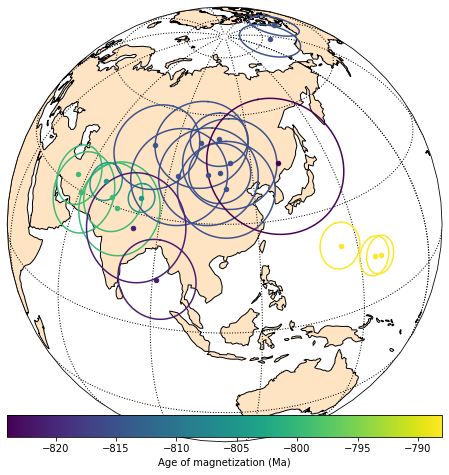

In [30]:
map_ax = ipmag.make_orthographic_map(figsize=(8,8), central_longitude=110, central_latitude=30, land_color='bisque')

# change the range of the colorbar to be between these two values
# this is to ensure a good dynamic range ~800 Ma where there are lots of poles
# then set the youngest pole to be at the limit of the colorbar
colorbar_max = np.max(SChina_compiled['age'])
colorbar_min = np.min(SChina_compiled['age'])

cmap = matplotlib.cm.get_cmap('viridis')
color_inds = -(SChina_compiled['age'].values.astype(np.float)-colorbar_max)/(colorbar_max-colorbar_min)
for i in range(len(color_inds)):
    if color_inds[i]>1:
        color_inds[i] = 1
colors = cmap(color_inds)

for i in range(len(SChina_compiled.index)):
    ipmag.plot_pole(map_ax,
                    SChina_compiled['lon'][i],SChina_compiled['lat'][i],SChina_compiled['a95'][i],
                    color=colors[i], edgecolor=colors[i])
    
# add the colorbar (note that this colorbar is not tied to the scatter above - it is manually created)
norm = matplotlib.colors.Normalize(vmin=-colorbar_min, vmax=-colorbar_max)
cax = inset_axes(plt.gca(), width='100%', height='5%', loc=8)
cbar = matplotlib.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, orientation='horizontal')
cbar.set_label('Age of magnetization (Ma)')

Color based on formation:

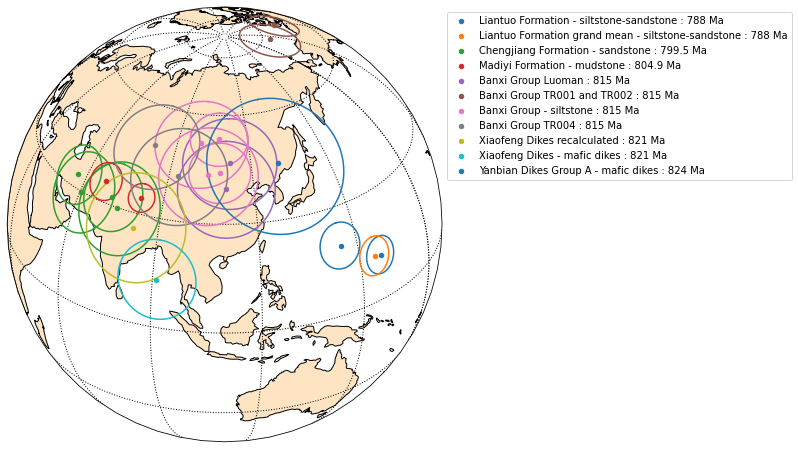

In [31]:
unique_rocks = SChina_compiled['rock'].unique().tolist()

map_ax = ipmag.make_orthographic_map(figsize=(8,8), central_longitude=110, central_latitude=30, land_color='bisque')

for i in range(len(unique_rocks)):
    this_slice = SChina_compiled[SChina_compiled['rock']==unique_rocks[i]].copy()
    this_slice.reset_index(drop=True,inplace=True)
    for j in range(len(this_slice)):
        if j==0:
            ipmag.plot_pole(map_ax,
                            this_slice['lon'][j],this_slice['lat'][j],this_slice['a95'][j],
                            color='C'+str(i), edgecolor='C'+str(i),
                            label=unique_rocks[i] + ' : ' + str(this_slice['age'][j]) + ' Ma')
        else:
            ipmag.plot_pole(map_ax,
                            this_slice['lon'][j],this_slice['lat'][j],this_slice['a95'][j],
                            color='C'+str(i), edgecolor='C'+str(i), label='__nolegend__')
    
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.show()

Select a few formations, and only plot the inclination-corrected poles:

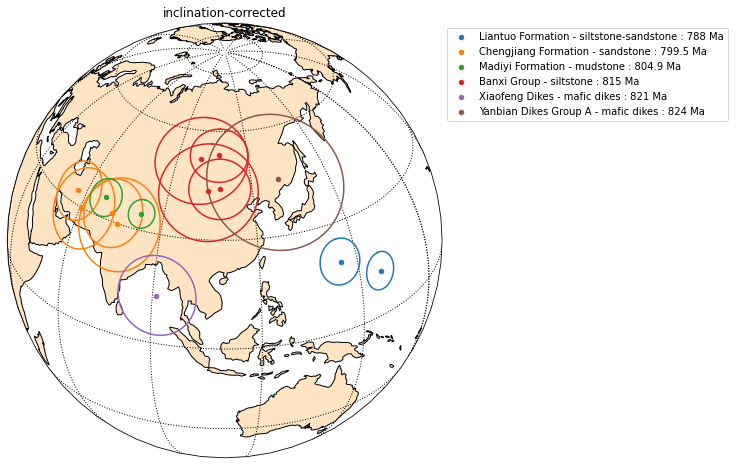

In [32]:
selected_rocks = ['Liantuo Formation - siltstone-sandstone',
                  'Chengjiang Formation - sandstone',
                  'Madiyi Formation - mudstone',
                  'Banxi Group - siltstone',
                  'Xiaofeng Dikes - mafic dikes',
                  'Yanbian Dikes Group A - mafic dikes']

map_ax = ipmag.make_orthographic_map(figsize=(8,8), central_longitude=110, central_latitude=30, land_color='bisque')

for i in range(len(selected_rocks)):
    this_slice = SChina_compiled[SChina_compiled['rock']==selected_rocks[i]].copy()
    if len(this_slice) > 1:
        this_slice = this_slice[this_slice['f']!=0].copy()
    this_slice.reset_index(drop=True,inplace=True)
    for j in range(len(this_slice)):
        if j==0:
            ipmag.plot_pole(map_ax,
                            this_slice['lon'][j],this_slice['lat'][j],this_slice['a95'][j],
                            color='C'+str(i), edgecolor='C'+str(i),
                            label=selected_rocks[i] + ' : ' + str(this_slice['age'][j]) + ' Ma')
        else:
            ipmag.plot_pole(map_ax,
                            this_slice['lon'][j],this_slice['lat'][j],this_slice['a95'][j],
                            color='C'+str(i), edgecolor='C'+str(i), label='__nolegend__')
    
plt.title('inclination-corrected')
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.show()

Same as above, but without inclination correction:

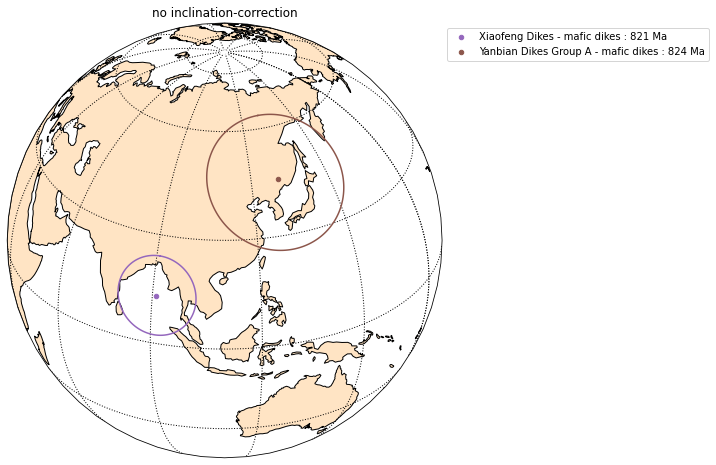

In [33]:
map_ax = ipmag.make_orthographic_map(figsize=(8,8), central_longitude=110, central_latitude=30, land_color='bisque')

for i in range(len(selected_rocks)):
    this_slice = SChina_compiled[SChina_compiled['rock']==selected_rocks[i]].copy()
    if len(this_slice) > 1:
        this_slice = this_slice[this_slice['f']==0].copy()
    this_slice.reset_index(drop=True,inplace=True)
    for j in range(len(this_slice)):
        if j==0:
            ipmag.plot_pole(map_ax,
                            this_slice['lon'][j],this_slice['lat'][j],this_slice['a95'][j],
                            color='C'+str(i), edgecolor='C'+str(i),
                            label=selected_rocks[i] + ' : ' + str(this_slice['age'][j]) + ' Ma')
        else:
            ipmag.plot_pole(map_ax,
                            this_slice['lon'][j],this_slice['lat'][j],this_slice['a95'][j],
                            color='C'+str(i), edgecolor='C'+str(i), label='__nolegend__')
    
plt.title('no inclination-correction')
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.show()

For the Banxi Group, select Luoman and TR004 only, and only the inclination-corrected poles:

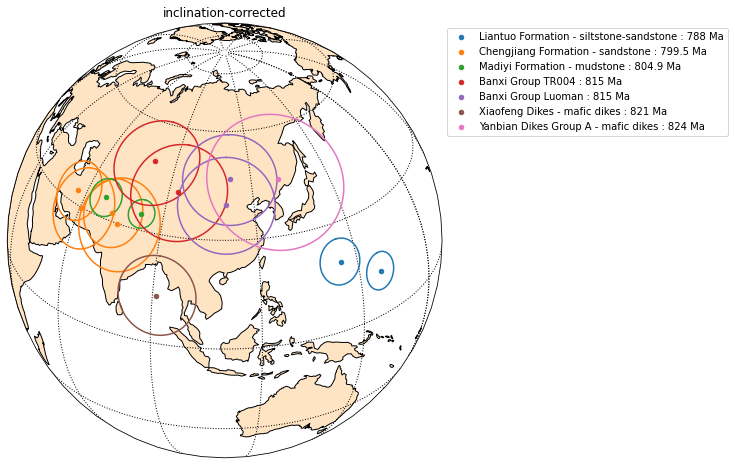

In [34]:
selected_rocks = ['Liantuo Formation - siltstone-sandstone',
                  'Chengjiang Formation - sandstone',
                  'Madiyi Formation - mudstone',
                  'Banxi Group TR004',
                  'Banxi Group Luoman',
                  'Xiaofeng Dikes - mafic dikes',
                  'Yanbian Dikes Group A - mafic dikes']

map_ax = ipmag.make_orthographic_map(figsize=(8,8), central_longitude=110, central_latitude=30, land_color='bisque')

for i in range(len(selected_rocks)):
    this_slice = SChina_compiled[SChina_compiled['rock']==selected_rocks[i]].copy()
    if len(this_slice) > 1:
        this_slice = this_slice[this_slice['f']!=0].copy()
    this_slice.reset_index(drop=True,inplace=True)
    for j in range(len(this_slice)):
        if j==0:
            ipmag.plot_pole(map_ax,
                            this_slice['lon'][j],this_slice['lat'][j],this_slice['a95'][j],
                            color='C'+str(i), edgecolor='C'+str(i),
                            label=selected_rocks[i] + ' : ' + str(this_slice['age'][j]) + ' Ma')
        else:
            ipmag.plot_pole(map_ax,
                            this_slice['lon'][j],this_slice['lat'][j],this_slice['a95'][j],
                            color='C'+str(i), edgecolor='C'+str(i), label='__nolegend__')
    
plt.title('inclination-corrected')
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.show()

Same as above, but without inclination correction:

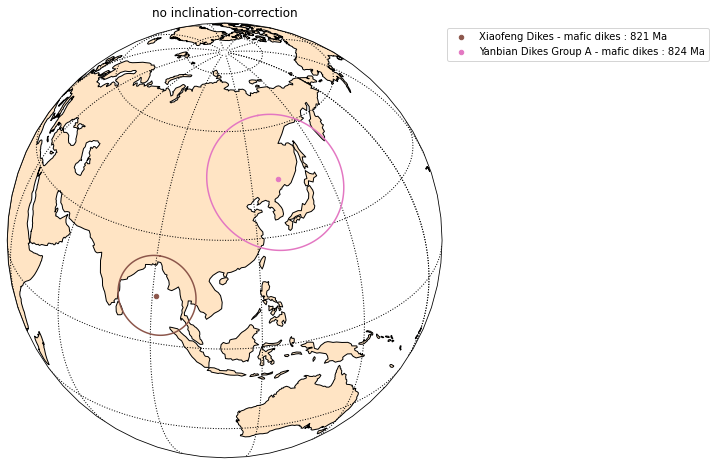

In [35]:
map_ax = ipmag.make_orthographic_map(figsize=(8,8), central_longitude=110, central_latitude=30, land_color='bisque')

for i in range(len(selected_rocks)):
    this_slice = SChina_compiled[SChina_compiled['rock']==selected_rocks[i]].copy()
    if len(this_slice) > 1:
        this_slice = this_slice[this_slice['f']==0].copy()
    this_slice.reset_index(drop=True,inplace=True)
    for j in range(len(this_slice)):
        if j==0:
            ipmag.plot_pole(map_ax,
                            this_slice['lon'][j],this_slice['lat'][j],this_slice['a95'][j],
                            color='C'+str(i), edgecolor='C'+str(i),
                            label=selected_rocks[i] + ' : ' + str(this_slice['age'][j]) + ' Ma')
        else:
            ipmag.plot_pole(map_ax,
                            this_slice['lon'][j],this_slice['lat'][j],this_slice['a95'][j],
                            color='C'+str(i), edgecolor='C'+str(i), label='__nolegend__')
    
plt.title('no inclination-correction')
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.show()

Directions at the Banxi Group site:

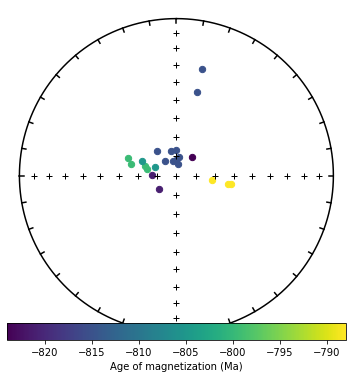

In [36]:
# approximately the mean coordinates of all sites on the E side of the mountains
slat = 27.95
slon = 108.83

# convert pole position to a direction at our Banxi sites
decs = np.array([])
incs = np.array([])
for i in range(len(SChina_compiled.index)):
    dec, inc = pmag.vgp_di(SChina_compiled['lat'][i], SChina_compiled['lon'][i], slat, slon)
    decs = np.append(decs, dec)
    incs = np.append(incs, inc)

# add to dataframe
SChina_compiled['dec'] = np.round(decs,1)
SChina_compiled['inc'] = np.round(incs,1)

fignum = 1
plt.figure(num=fignum,figsize=(5,5))
ipmag.plot_net(fignum)

for i in range(len(decs)):
    ipmag.plot_di(dec=decs[i],inc=incs[i],color=colors[i],markersize=40)
    
# add the colorbar (note that this colorbar is not tied to the scatter above - it is manually created)
norm = matplotlib.colors.Normalize(vmin=-colorbar_min, vmax=-colorbar_max)
cax = inset_axes(plt.gca(), width='100%', height='5%', loc=8)
cbar = matplotlib.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, orientation='horizontal')
cbar.set_label('Age of magnetization (Ma)')
plt.show()

## South China - Phanerozoic

Set up compilation dataframe:

In [37]:
later_compiled_cols = ['age',
                       'age upper',
                       'age lower',
                       'lat',
                       'lon',
                       'a95',
                       'formation/lithology/location',
                       'reference',
                       'note']

SChina_later_compiled = pd.DataFrame(columns=later_compiled_cols)

j = 0

The following post-late Paleozoic poles were taken from the compilation in Wu et al. (2017), Table 1:

In [38]:
Wu2017_df = pd.read_csv('../Data/Wu2017a_SouthChina.csv')

for i in range(len(Wu2017_df.index)):
    if np.isfinite(Wu2017_df['lonP_IFcorr'][i]):
        SChina_later_compiled.loc[j, 'lat'] = Wu2017_df['latP_IFcorr'][i]
        SChina_later_compiled.loc[j, 'lon'] = Wu2017_df['lonP_IFcorr'][i]
    else:
        SChina_later_compiled.loc[j, 'lat'] = Wu2017_df['latP'][i]
        SChina_later_compiled.loc[j, 'lon'] = Wu2017_df['lonP'][i]
    SChina_later_compiled.loc[j, 'a95'] = Wu2017_df['a95'][i]
    SChina_later_compiled.loc[j, 'age'] = Wu2017_df['Age (Ma)'][i]
    SChina_later_compiled.loc[j, 'reference'] = Wu2017_df['Reference'][i]
    SChina_later_compiled.loc[j, 'formation/lithology/location'] = Wu2017_df['Host rock lithology, location'][i]
    SChina_later_compiled.loc[j, 'note'] = '-'
    j = j + 1

The following Silurian pole was taken from Huang et al. (2000):

In [39]:
SChina_later_compiled.loc[j, 'age'] = 430
SChina_later_compiled.loc[j, 'age upper'] = np.nan
SChina_later_compiled.loc[j, 'age lower'] = np.nan
SChina_later_compiled.loc[j, 'lat'] = 14.9
SChina_later_compiled.loc[j, 'lon'] = 196.1
SChina_later_compiled.loc[j, 'a95'] = 5.1
SChina_later_compiled.loc[j, 'formation/lithology/location'] = 'Leijitun Section'
SChina_later_compiled.loc[j, 'reference'] = 'Huang et al. (2000)'
SChina_later_compiled.loc[j, 'note'] = '-'
j = j + 1

The following late Ordovician pole was taken from Han et al. (2015):

In [40]:
SChina_later_compiled.loc[j, 'age'] = 456
SChina_later_compiled.loc[j, 'age upper'] = np.nan
SChina_later_compiled.loc[j, 'age lower'] = np.nan
SChina_later_compiled.loc[j, 'lat'] = -45.8
SChina_later_compiled.loc[j, 'lon'] = 191.3
SChina_later_compiled.loc[j, 'a95'] = np.sqrt(4.2 * 2.4)
SChina_later_compiled.loc[j, 'formation/lithology/location'] = 'Pagoda Formation'
SChina_later_compiled.loc[j, 'reference'] = 'Han et al. (2015)'
SChina_later_compiled.loc[j, 'note'] = '-'
j = j + 1

The following middle Cambrian pole was taken from Yang et al. (2004):

In [41]:
SChina_later_compiled.loc[j, 'age'] = 510
SChina_later_compiled.loc[j, 'age upper'] = np.nan
SChina_later_compiled.loc[j, 'age lower'] = np.nan
SChina_later_compiled.loc[j, 'lat'] = -51.3
SChina_later_compiled.loc[j, 'lon'] = 166.0
SChina_later_compiled.loc[j, 'a95'] = np.sqrt(4.4 * 8.6)
SChina_later_compiled.loc[j, 'formation/lithology/location'] = 'Douposi Formation'
SChina_later_compiled.loc[j, 'reference'] = 'Yang et al. (2004)'
SChina_later_compiled.loc[j, 'note'] = '-'
j = j + 1

The following Ediacaran pole was taken from Macouin et al. (2004):

In [42]:
SChina_later_compiled.loc[j, 'age'] = 584
SChina_later_compiled.loc[j, 'age upper'] = np.nan
SChina_later_compiled.loc[j, 'age lower'] = np.nan
SChina_later_compiled.loc[j, 'lat'] = 0.6
SChina_later_compiled.loc[j, 'lon'] = 196.9
SChina_later_compiled.loc[j, 'a95'] = np.sqrt(4.5 * 9.0)
SChina_later_compiled.loc[j, 'formation/lithology/location'] = 'Doushantuo Formation'
SChina_later_compiled.loc[j, 'reference'] = 'Macouin et al. (2004)'
SChina_later_compiled.loc[j, 'note'] = '-'
j = j + 1

The following poles were taken from the compilation in Zhang et al. (2015), Table 2:

Note:

* ages are approximated based on the period/epoch provided in the table
* '?' indicate references that are unavailable

In [43]:
Zhang2015_df = pd.DataFrame({'lat':[65.3,47.5,45.4,36.1,-29.5,-38.4,23.9],
                             'lon':[265.2,229.1,234.1,231.4,227.1,154.9,187.0],
                             'a95':[np.sqrt(8.1*4.2),np.sqrt(9.6*4.8),np.sqrt(6.6*3.3),np.sqrt(12.5*6.5),6.3,
                                    np.sqrt(14.2*7.4),np.sqrt(3.0*1.8)],
                             'age':[290,340,370,400,460,480,580],
                             'reference':['Wu et al. (1998)','Zhang et al. (2001)','Zhang et al. (2001)',
                                          'Zhang et al. (2001)','Zhang et al. (2012)','Wu et al. (1998)',
                                          'Zhang et al. (2015)'],
                             'formation/lithology/location':['Limestone; Xingshan, Hubei','?','?','?','?',
                                                             'Limestone; Xingshan, Hubei','Doushantuo Formation']})

The following Cryogenian poles were taken from the compilation in Zhang et al. (2013), Table 2:

In [44]:
Zhang2013_df = pd.DataFrame({'lat':[9.3,0.2],
                             'lon':[165.9,151.2],
                             'a95':[4.3,np.sqrt(7.5*5.4)],
                             'age':[636,636],
                             'reference':['Zhang et al. (2013)','Zhang and Piper (1997)'],
                             'formation/lithology/location':['Nantuo Formation','Nantuo Formation']})

Put it all together:

In [45]:
SChina_later_compiled = pd.concat([SChina_later_compiled, Zhang2013_df, Zhang2015_df], ignore_index=True)
SChina_later_compiled.sort_values('age', inplace=True)
SChina_later_compiled = SChina_later_compiled[later_compiled_cols]
SChina_later_compiled.reset_index(inplace=True, drop=True)
SChina_later_compiled

,age,age upper,age lower,lat,lon,a95,formation/lithology/location,reference,note
0,61,NaN,NaN,74.9,191.9,6.5,Sandstone; Yunnan,Yoshioka et al. (2003),-
1,61,NaN,NaN,86.1,99.2,4.4,Sandstone; Hunan,Sun et al. (2006),-
2,61,NaN,NaN,77.2,223.7,3.5,Sediments; Jiangxi,Clyde et al. (2008),-
3,61,NaN,NaN,79.6,231.3,5.6,Sediments; Hunan,Bowen et al. (2002),-
4,61,NaN,NaN,80.6,141.3,8.5,Sandstone; Guangxi,Zhao et al. (1994),-
5,66,NaN,NaN,76.7,144.9,6.7,Sandstone; Anhui,Gilder et al. (1999),-
6,80,NaN,NaN,69.3,211.2,8.9,Dykes; Hongkong,Li et al. (2005),-
7,83.3,NaN,NaN,65.9,174.7,3.2,Sandstone; Yunnan,Otofuji et al. (1998),-
8,83.3,NaN,NaN,79.6,142.1,7.1,Sediments; Sichuan,Huang and Opdyke (1992),-
9,83.3,NaN,NaN,76,204.4,4.7,Redbeds; Hunan,Sun et al. (2006),-


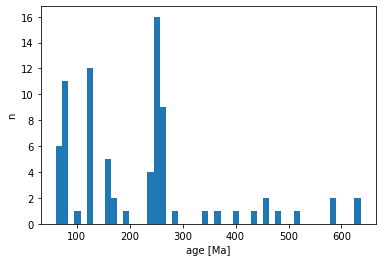

In [46]:
fig, ax = plt.subplots()
ax.hist(SChina_later_compiled['age'], bins=50)
ax.set_xlabel('age [Ma]')
ax.set_ylabel('n')
plt.show(fig)

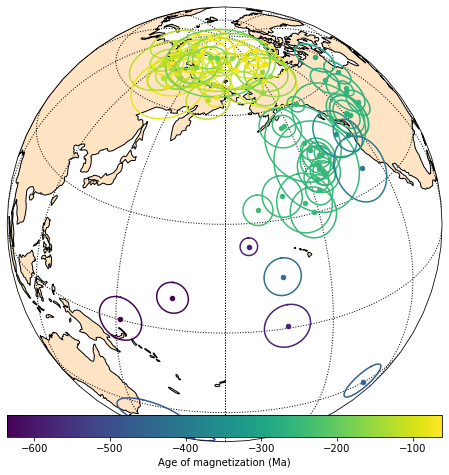

In [47]:
map_ax = ipmag.make_orthographic_map(figsize=(8,8), central_longitude=180, central_latitude=30, land_color='bisque')

# change the range of the colorbar to be between these two values
# this is to ensure a good dynamic range ~800 Ma where there are lots of poles
# then set the youngest pole to be at the limit of the colorbar
colorbar_max = np.max(SChina_later_compiled['age'])
colorbar_min = np.min(SChina_later_compiled['age'])

cmap = matplotlib.cm.get_cmap('viridis')
color_inds = -(SChina_later_compiled['age'].values.astype(np.float)-colorbar_max)/(colorbar_max-colorbar_min)
for i in range(len(color_inds)):
    if color_inds[i]>1:
        color_inds[i] = 1
colors = cmap(color_inds)

for i in range(len(SChina_later_compiled.index)):
    ipmag.plot_pole(map_ax,
                    SChina_later_compiled['lon'][i],SChina_later_compiled['lat'][i],SChina_later_compiled['a95'][i],
                    color=colors[i], edgecolor=colors[i])
    
# add the colorbar (note that this colorbar is not tied to the scatter above - it is manually created)
norm = matplotlib.colors.Normalize(vmin=-colorbar_min, vmax=-colorbar_max)
cax = inset_axes(plt.gca(), width='100%', height='5%', loc=8)
cbar = matplotlib.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, orientation='horizontal')
cbar.set_label('Age of magnetization (Ma)')

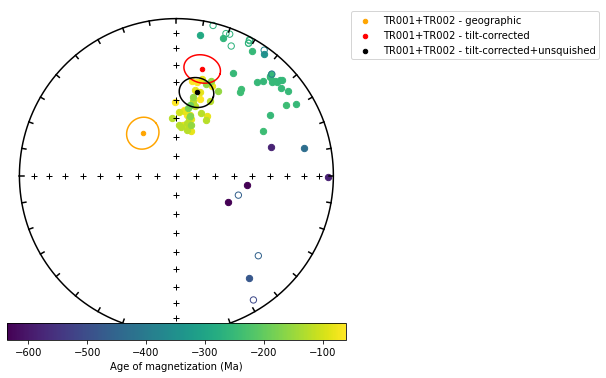

In [48]:
# convert pole position to a direction at our Banxi sites
decs = np.array([])
incs = np.array([])
for i in range(len(SChina_later_compiled.index)):
    dec, inc = pmag.vgp_di(SChina_later_compiled['lat'][i], SChina_later_compiled['lon'][i], slat, slon)
    decs = np.append(decs, dec)
    incs = np.append(incs, inc)

# add to dataframe
SChina_later_compiled['dec'] = np.round(decs,1)
SChina_later_compiled['inc'] = np.round(incs,1)

fignum = 1
plt.figure(num=fignum,figsize=(5,5))
ipmag.plot_net(fignum)

for i in range(len(decs)):
    ipmag.plot_di(dec=decs[i],inc=incs[i],color=colors[i],markersize=40)
    
# add the inconsistent Banxi directions
ipmag.plot_di_mean(321.6,61.7,8.3,color='orange',label='TR001+TR002 - geographic')
ipmag.plot_di_mean(13.6,30.6,8.3,color='red',label='TR001+TR002 - tilt-corrected')
ipmag.plot_di_mean(13.6,ipmag.unsquish(30.6,0.6),8.3,color='k',label='TR001+TR002 - tilt-corrected+unsquished')
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
    
# add the colorbar (note that this colorbar is not tied to the scatter above - it is manually created)
norm = matplotlib.colors.Normalize(vmin=-colorbar_min, vmax=-colorbar_max)
cax = inset_axes(plt.gca(), width='100%', height='5%', loc=8)
cbar = matplotlib.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, orientation='horizontal')
cbar.set_label('Age of magnetization (Ma)')

## South China Analysis

Paleolatitude at our Banxi sites:

In [49]:
SChina_compiled['Banxi_paleolat'] = pd.Series()
SChina_compiled['temp_xerr_lower'] = pd.Series()
SChina_compiled['temp_xerr_upper'] = pd.Series()

for i in range(len(SChina_compiled)):
    SChina_compiled['Banxi_paleolat'][i] = ipmag.lat_from_pole(slon, slat,
                                                               SChina_compiled['lon'][i], SChina_compiled['lat'][i])
    
    if np.isnan(SChina_compiled['age lower (reported)'][i]):
        SChina_compiled['temp_xerr_lower'][i] = 0
    else:
        SChina_compiled['temp_xerr_lower'][i] = SChina_compiled['age lower (reported)'][i] - SChina_compiled['age'][i]
        
    if np.isnan(SChina_compiled['age upper (reported)'][i]):
        SChina_compiled['temp_xerr_upper'][i] = 0
    else:
        SChina_compiled['temp_xerr_upper'][i] = SChina_compiled['age'][i] - SChina_compiled['age upper (reported)'][i]

Select a few poles to plot:

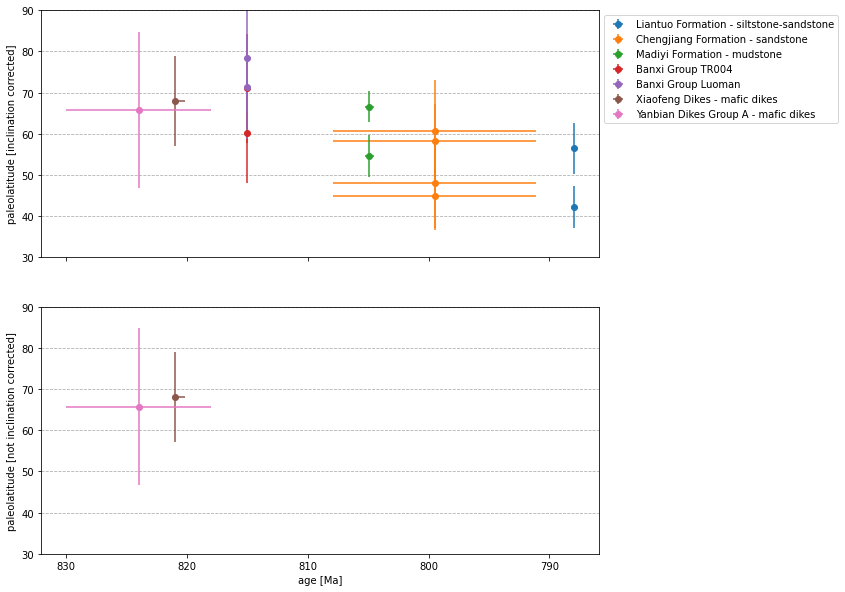

In [50]:
selected_rocks = ['Liantuo Formation - siltstone-sandstone',
                  'Chengjiang Formation - sandstone',
                  'Madiyi Formation - mudstone',
                  'Banxi Group TR004',
                  'Banxi Group Luoman',
                  'Xiaofeng Dikes - mafic dikes',
                  'Yanbian Dikes Group A - mafic dikes']

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,10), sharex=True, sharey=True)

for i in range(len(selected_rocks)):
    this_slice = SChina_compiled[SChina_compiled['rock']==selected_rocks[i]].copy()
    if len(this_slice) > 1:
        this_slice = this_slice[this_slice['f']!=0].copy()
    this_slice.reset_index(drop=True,inplace=True)
    for j in range(len(this_slice)):
        if j==0:
            ax[0].errorbar(this_slice['age'][j],
                           this_slice['Banxi_paleolat'][j],
                           yerr=this_slice['a95'][j],
                           xerr=[[this_slice['temp_xerr_lower'][j]], [this_slice['temp_xerr_upper'][j]]],
                           fmt='o', color='C'+str(i), label=selected_rocks[i])
        else:
            ax[0].errorbar(this_slice['age'][j],
                           this_slice['Banxi_paleolat'][j],
                           yerr=this_slice['a95'][j],
                           xerr=[[this_slice['temp_xerr_lower'][j]], [this_slice['temp_xerr_upper'][j]]],
                           fmt='o', color='C'+str(i), label='__nolegend__')

ax[0].legend(loc='upper left', bbox_to_anchor=(1,1))
ax[0].set_ylabel('paleolatitude [inclination corrected]')

for i in range(len(selected_rocks)):
    this_slice = SChina_compiled[SChina_compiled['rock']==selected_rocks[i]].copy()
    if len(this_slice) > 1:
        this_slice = this_slice[this_slice['f']==0].copy()
    this_slice.reset_index(drop=True,inplace=True)
    for j in range(len(this_slice)):
        if j==0:
            ax[1].errorbar(this_slice['age'][j],
                           this_slice['Banxi_paleolat'][j],
                           yerr=this_slice['a95'][j],
                           xerr=[[this_slice['temp_xerr_lower'][j]], [this_slice['temp_xerr_upper'][j]]],
                           fmt='o', color='C'+str(i), label=selected_rocks[i])
        else:
            ax[1].errorbar(this_slice['age'][j],
                           this_slice['Banxi_paleolat'][j],
                           yerr=this_slice['a95'][j],
                           xerr=[[this_slice['temp_xerr_lower'][j]], [this_slice['temp_xerr_upper'][j]]],
                           fmt='o', color='C'+str(i), label='__nolegend__')

ax[1].set_ylabel('paleolatitude [not inclination corrected]')

ax[0].yaxis.grid(ls='--')
ax[1].yaxis.grid(ls='--')
ax[1].set_ylim(30,90)
ax[1].set_xlabel('age [Ma]')
ax[1].invert_xaxis()

plt.show(fig)

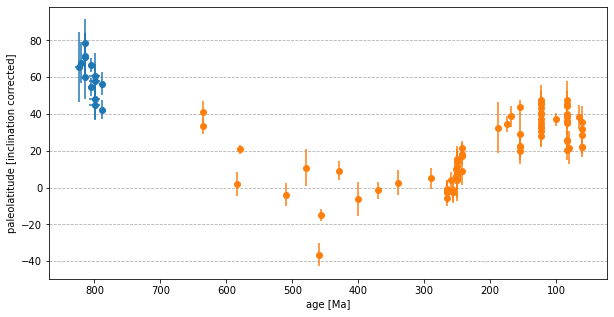

In [51]:
SChina_later_compiled['Banxi_paleolat'] = pd.Series()

for i in range(len(SChina_later_compiled)):
    SChina_later_compiled['Banxi_paleolat'][i] = ipmag.lat_from_pole(slon, slat,
                                                                     SChina_later_compiled['lon'][i],
                                                                     SChina_later_compiled['lat'][i])

fig, ax = plt.subplots(figsize=(10,5))

for i in range(len(selected_rocks)):
    this_slice = SChina_compiled[SChina_compiled['rock']==selected_rocks[i]].copy()
    if len(this_slice) > 1:
        this_slice = this_slice[this_slice['f']!=0].copy()
    this_slice.reset_index(drop=True,inplace=True)
    ax.errorbar(this_slice['age'],
                this_slice['Banxi_paleolat'],
                yerr=this_slice['a95'],
                xerr=[this_slice['temp_xerr_lower'], this_slice['temp_xerr_upper']],
                fmt='o', color='C0')
            
ax.errorbar(SChina_later_compiled['age'],
            SChina_later_compiled['Banxi_paleolat'],
            yerr=SChina_later_compiled['a95'],
            fmt='o', color='C1')

ax.set_ylabel('paleolatitude [inclination corrected]')
ax.yaxis.grid(ls='--')
ax.set_xlabel('age [Ma]')
ax.invert_xaxis()

plt.show(fig)

## India

In [52]:
India_compiled = pd.DataFrame(columns=compiled_cols)

j = 0

### Malani Dikes

In [53]:
India_compiled.loc[j, 'age'] = 759
India_compiled.loc[j, 'age upper (reported)'] = 759 - 12
India_compiled.loc[j, 'age lower (reported)'] = 759 + 12
India_compiled.loc[j, 'age upper (estimate)'] = 752 - 18
India_compiled.loc[j, 'age lower (estimate)'] = 759 + 12
India_compiled.loc[j, 'lat'] = 69.4
India_compiled.loc[j, 'lon'] = 75.7
India_compiled.loc[j, 'a95'] = 6.5
India_compiled.loc[j, 'rock'] = 'Malani Dikes - mafic dikes'
India_compiled.loc[j, 'f'] = 1
India_compiled.loc[j, 'slat'] = 25.3
India_compiled.loc[j, 'slon'] = 72.6
India_compiled.loc[j, 'dec'] = 2.9
India_compiled.loc[j, 'inc'] = 63.7
India_compiled.loc[j, 'dir_a95'] = 4.2
India_compiled.loc[j, 'pole reference'] = 'Meert et al. (2013)'
India_compiled.loc[j, 'age reference'] = 'Meert et al. (2013) - LA on dike'
India_compiled.loc[j, 'grade'] = 'A - baked contact test'
India_compiled.loc[j, 'note'] = 'All zircons are off concordia - 759 +/- 12 is the intercept age, and 752 +/- 18 is the 207Pb/206Pb age.'
j = j + 1

### Banganapalli Quartzite

In [54]:
India_compiled.loc[j, 'age'] = 589
India_compiled.loc[j, 'age upper (reported)'] = 543
India_compiled.loc[j, 'age lower (reported)'] = 635
India_compiled.loc[j, 'age upper (estimate)'] = 543
India_compiled.loc[j, 'age lower (estimate)'] = 635
India_compiled.loc[j, 'lat'] = -73.5
India_compiled.loc[j, 'lon'] = 53.6
India_compiled.loc[j, 'a95'] = 3.7
India_compiled.loc[j, 'rock'] = 'Banganapalli Quartzite'
India_compiled.loc[j, 'f'] = 1
India_compiled.loc[j, 'slat'] = 16
India_compiled.loc[j, 'slon'] = 79
India_compiled.loc[j, 'dec'] = 7
India_compiled.loc[j, 'inc'] = 1.3
India_compiled.loc[j, 'dir_a95'] = np.nan
India_compiled.loc[j, 'pole reference'] = 'Goutham et al. (2006)'
India_compiled.loc[j, 'age reference'] = '?'
India_compiled.loc[j, 'grade'] = 'B'
India_compiled.loc[j, 'note'] = 'Taken directly from Leirubakki compilation.'
j = j + 1

In [55]:
India_compiled.loc[j, 'age'] = 589
India_compiled.loc[j, 'age upper (reported)'] = 543
India_compiled.loc[j, 'age lower (reported)'] = 635
India_compiled.loc[j, 'age upper (estimate)'] = 543
India_compiled.loc[j, 'age lower (estimate)'] = 635
India_compiled.loc[j, 'lat'] = 73.6
India_compiled.loc[j, 'lon'] = 233.5
India_compiled.loc[j, 'a95'] = 3.7
India_compiled.loc[j, 'rock'] = 'Banganapalli Quartzite'
India_compiled.loc[j, 'f'] = 0.6
India_compiled.loc[j, 'slat'] = 16
India_compiled.loc[j, 'slon'] = 79
India_compiled.loc[j, 'dec'] = 7
India_compiled.loc[j, 'inc'] = 2.2
India_compiled.loc[j, 'dir_a95'] = np.nan
India_compiled.loc[j, 'pole reference'] = 'Goutham et al. (2006)'
India_compiled.loc[j, 'age reference'] = '?'
India_compiled.loc[j, 'grade'] = 'B'
India_compiled.loc[j, 'note'] = 'Taken directly from Leirubakki compilation.'
j = j + 1

### Mahoba Dikes

In [56]:
India_compiled.loc[j, 'age'] = 1113
India_compiled.loc[j, 'age upper (reported)'] = 1113 - 7.4
India_compiled.loc[j, 'age lower (reported)'] = 1113 + 7.4
India_compiled.loc[j, 'age upper (estimate)'] = 1113 - 7.4
India_compiled.loc[j, 'age lower (estimate)'] = 1113 + 7.4
India_compiled.loc[j, 'lat'] = 38.7
India_compiled.loc[j, 'lon'] = 229.5
India_compiled.loc[j, 'a95'] = 12.4
India_compiled.loc[j, 'rock'] = 'Mahoba Dikes'
India_compiled.loc[j, 'f'] = 1
India_compiled.loc[j, 'slat'] = 25.2
India_compiled.loc[j, 'slon'] = 80
India_compiled.loc[j, 'dec'] = 24.7
India_compiled.loc[j, 'inc'] = -37.9
India_compiled.loc[j, 'dir_a95'] = np.nan
India_compiled.loc[j, 'pole reference'] = 'Pradhan et al. (2012)'
India_compiled.loc[j, 'age reference'] = '?'
India_compiled.loc[j, 'grade'] = 'B'
India_compiled.loc[j, 'note'] = 'Taken directly from Leirubakki compilation - labelled as India-North.'
j = j + 1

### Majhgawan Kimberlite

In [57]:
India_compiled.loc[j, 'age'] = 1073.5
India_compiled.loc[j, 'age upper (reported)'] = 1073.5 - 13.5
India_compiled.loc[j, 'age lower (reported)'] = 1073.5 + 13.5
India_compiled.loc[j, 'age upper (estimate)'] = 1073.5 - 13.5
India_compiled.loc[j, 'age lower (estimate)'] = 1073.5 + 13.5
India_compiled.loc[j, 'lat'] = 36.8
India_compiled.loc[j, 'lon'] = 212.5
India_compiled.loc[j, 'a95'] = 12.2
India_compiled.loc[j, 'rock'] = 'Majhgawan Kimberlite'
India_compiled.loc[j, 'f'] = 1
India_compiled.loc[j, 'slat'] = 24.7
India_compiled.loc[j, 'slon'] = 80.1
India_compiled.loc[j, 'dec'] = 37.5
India_compiled.loc[j, 'inc'] = -26.5
India_compiled.loc[j, 'dir_a95'] = np.nan
India_compiled.loc[j, 'pole reference'] = 'Gregory et al. (2006)'
India_compiled.loc[j, 'age reference'] = '?'
India_compiled.loc[j, 'grade'] = 'B'
India_compiled.loc[j, 'note'] = 'Taken directly from Leirubakki compilation - labelled as India-North.'
j = j + 1

### Compiled

In [58]:
India_compiled.sort_values('age', inplace=True)
India_compiled = India_compiled[compiled_cols]
India_compiled.reset_index(inplace=True, drop=True)
India_compiled

,age,age upper (reported),age lower (reported),age upper (estimate),age lower (estimate),lat,lon,a95,rock,f,slat,slon,dec,inc,dir_a95,pole reference,age reference,grade,note
0,589,543,635,543,635,-73.5,53.6,3.7,Banganapalli Quartzite,1,16,79,7,1.3,NaN,Goutham et al. (2006),?,B,Taken directly from Leirubakki compilation.
1,589,543,635,543,635,73.6,233.5,3.7,Banganapalli Quartzite,0.6,16,79,7,2.2,NaN,Goutham et al. (2006),?,B,Taken directly from Leirubakki compilation.
2,759,747,771,734,771,69.4,75.7,6.5,Malani Dikes - mafic dikes,1,25.3,72.6,2.9,63.7,4.2,Meert et al. (2013),Meert et al. (2013) - LA on dike,A - baked contact test,All zircons are off concordia - 759 +/- 12 is ...
3,1073.5,1060,1087,1060,1087,36.8,212.5,12.2,Majhgawan Kimberlite,1,24.7,80.1,37.5,-26.5,NaN,Gregory et al. (2006),?,B,Taken directly from Leirubakki compilation - l...
4,1113,1105.6,1120.4,1105.6,1120.4,38.7,229.5,12.4,Mahoba Dikes,1,25.2,80,24.7,-37.9,NaN,Pradhan et al. (2012),?,B,Taken directly from Leirubakki compilation - l...


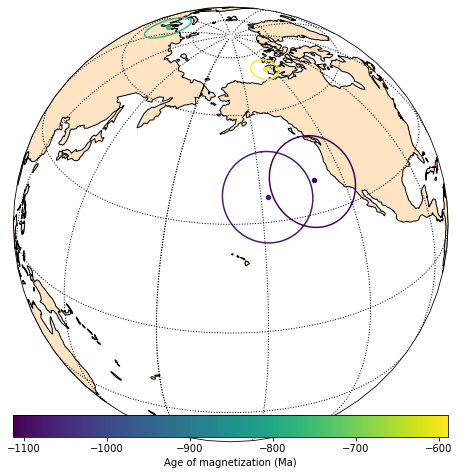

In [59]:
selected_inds = np.array([1,2,3,4])

map_ax = ipmag.make_orthographic_map(figsize=(8,8), central_longitude=200, central_latitude=30, land_color='bisque')

# change the range of the colorbar to be between these two values
# this is to ensure a good dynamic range ~800 Ma where there are lots of poles
# then set the youngest pole to be at the limit of the colorbar
colorbar_max = np.max(India_compiled['age'])
colorbar_min = np.min(India_compiled['age'])

cmap = matplotlib.cm.get_cmap('viridis')
color_inds = -(India_compiled['age'].values.astype(np.float)-colorbar_max)/(colorbar_max-colorbar_min)
for i in range(len(color_inds)):
    if color_inds[i]>1:
        color_inds[i] = 1
colors = cmap(color_inds)

for i in selected_inds:
    ipmag.plot_pole(map_ax,
                    India_compiled['lon'][i],India_compiled['lat'][i],India_compiled['a95'][i],
                    color=colors[i], edgecolor=colors[i])
    
# add the colorbar (note that this colorbar is not tied to the scatter above - it is manually created)
norm = matplotlib.colors.Normalize(vmin=-colorbar_min, vmax=-colorbar_max)
cax = inset_axes(plt.gca(), width='100%', height='5%', loc=8)
cbar = matplotlib.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, orientation='horizontal')
cbar.set_label('Age of magnetization (Ma)')

## Australia

In [60]:
Australia_compiled = pd.DataFrame(columns=compiled_cols)

j = 0

### Angepena Formation

In [61]:
Australia_compiled.loc[j, 'age'] = 650
Australia_compiled.loc[j, 'age upper (reported)'] = 640
Australia_compiled.loc[j, 'age lower (reported)'] = 660
Australia_compiled.loc[j, 'age upper (estimate)'] = 640
Australia_compiled.loc[j, 'age lower (estimate)'] = 660
Australia_compiled.loc[j, 'lat'] = 45.2
Australia_compiled.loc[j, 'lon'] = 174.2
Australia_compiled.loc[j, 'a95'] = 4.6
Australia_compiled.loc[j, 'rock'] = 'Angepena Formation'
Australia_compiled.loc[j, 'f'] = 0.6
Australia_compiled.loc[j, 'slat'] = -31
Australia_compiled.loc[j, 'slon'] = 138
Australia_compiled.loc[j, 'dec'] = 24.8
Australia_compiled.loc[j, 'inc'] = 13.8
Australia_compiled.loc[j, 'dir_a95'] = np.nan
Australia_compiled.loc[j, 'pole reference'] = '?'
Australia_compiled.loc[j, 'age reference'] = '?'
Australia_compiled.loc[j, 'grade'] = 'B'
Australia_compiled.loc[j, 'note'] = 'Taken directly from Leirubakki compilation. Younger than c. 659 Ma Wilyerpa Fm, older that c. 635 Ma Elatina Fm'
j = j + 1

In [62]:
Australia_compiled.loc[j, 'age'] = 650
Australia_compiled.loc[j, 'age upper (reported)'] = 640
Australia_compiled.loc[j, 'age lower (reported)'] = 660
Australia_compiled.loc[j, 'age upper (estimate)'] = 640
Australia_compiled.loc[j, 'age lower (estimate)'] = 660
Australia_compiled.loc[j, 'lat'] = 47.1
Australia_compiled.loc[j, 'lon'] = 176.6
Australia_compiled.loc[j, 'a95'] = 5.3
Australia_compiled.loc[j, 'rock'] = 'Angepena Formation'
Australia_compiled.loc[j, 'f'] = 1
Australia_compiled.loc[j, 'slat'] = -31
Australia_compiled.loc[j, 'slon'] = 138
Australia_compiled.loc[j, 'dec'] = 24.8
Australia_compiled.loc[j, 'inc'] = 8.4
Australia_compiled.loc[j, 'dir_a95'] = np.nan
Australia_compiled.loc[j, 'pole reference'] = '?'
Australia_compiled.loc[j, 'age reference'] = '?'
Australia_compiled.loc[j, 'grade'] = 'B'
Australia_compiled.loc[j, 'note'] = 'Taken directly from Leirubakki compilation. Younger than c. 659 Ma Wilyerpa Fm, older that c. 635 Ma Elatina Fm'
j = j + 1

### Mundine Well Dykes Combined

In [63]:
Australia_compiled.loc[j, 'age'] = 755
Australia_compiled.loc[j, 'age upper (reported)'] = 752
Australia_compiled.loc[j, 'age lower (reported)'] = 758
Australia_compiled.loc[j, 'age upper (estimate)'] = 752
Australia_compiled.loc[j, 'age lower (estimate)'] = 758
Australia_compiled.loc[j, 'lat'] = 45.3
Australia_compiled.loc[j, 'lon'] = 135.4
Australia_compiled.loc[j, 'a95'] = 4.1
Australia_compiled.loc[j, 'rock'] = 'Mundine Well Dykes Combined'
Australia_compiled.loc[j, 'f'] = 1
Australia_compiled.loc[j, 'slat'] = -25.5
Australia_compiled.loc[j, 'slon'] = 115
Australia_compiled.loc[j, 'dec'] = 14.8
Australia_compiled.loc[j, 'inc'] = 31.1
Australia_compiled.loc[j, 'dir_a95'] = np.nan
Australia_compiled.loc[j, 'pole reference'] = 'Wingate et al. (2000)'
Australia_compiled.loc[j, 'age reference'] = 'Wingate et al. (2000)'
Australia_compiled.loc[j, 'grade'] = 'A'
Australia_compiled.loc[j, 'note'] = 'Taken directly from Leirubakki compilation.'
j = j + 1

### Johnny's Creek

In [64]:
Australia_compiled.loc[j, 'age'] = 760
Australia_compiled.loc[j, 'age upper (reported)'] = 730
Australia_compiled.loc[j, 'age lower (reported)'] = 790
Australia_compiled.loc[j, 'age upper (estimate)'] = 730
Australia_compiled.loc[j, 'age lower (estimate)'] = 790
Australia_compiled.loc[j, 'lat'] = 15.8
Australia_compiled.loc[j, 'lon'] = 83
Australia_compiled.loc[j, 'a95'] = 13.5
Australia_compiled.loc[j, 'rock'] = 'Johnnys Creek Siltstone'
Australia_compiled.loc[j, 'f'] = 1
Australia_compiled.loc[j, 'slat'] = -24
Australia_compiled.loc[j, 'slon'] = 133.5
Australia_compiled.loc[j, 'dec'] = 122.8
Australia_compiled.loc[j, 'inc'] = -44.6
Australia_compiled.loc[j, 'dir_a95'] = np.nan
Australia_compiled.loc[j, 'pole reference'] = 'Swanson-Hysell et al. (2012)'
Australia_compiled.loc[j, 'age reference'] = 'Swanson-Hysell et al. (2012)'
Australia_compiled.loc[j, 'grade'] = 'B'
Australia_compiled.loc[j, 'note'] = 'Taken directly from Leirubakki compilation. Age from correlations.'
j = j + 1

In [65]:
Australia_compiled.loc[j, 'age'] = 760
Australia_compiled.loc[j, 'age upper (reported)'] = 730
Australia_compiled.loc[j, 'age lower (reported)'] = 790
Australia_compiled.loc[j, 'age upper (estimate)'] = 730
Australia_compiled.loc[j, 'age lower (estimate)'] = 790
Australia_compiled.loc[j, 'lat'] = -7.1
Australia_compiled.loc[j, 'lon'] = 272.6
Australia_compiled.loc[j, 'a95'] = 14.7
Australia_compiled.loc[j, 'rock'] = 'Johnnys Creek Siltstone'
Australia_compiled.loc[j, 'f'] = 0.6
Australia_compiled.loc[j, 'slat'] = -24
Australia_compiled.loc[j, 'slon'] = 133.5
Australia_compiled.loc[j, 'dec'] = 122.8
Australia_compiled.loc[j, 'inc'] = -58.7
Australia_compiled.loc[j, 'dir_a95'] = np.nan
Australia_compiled.loc[j, 'pole reference'] = 'Swanson-Hysell et al. (2012)'
Australia_compiled.loc[j, 'age reference'] = 'Swanson-Hysell et al. (2012)'
Australia_compiled.loc[j, 'grade'] = 'B'
Australia_compiled.loc[j, 'note'] = 'Taken directly from Leirubakki compilation. Age from correlations.'
j = j + 1

### Lancer Core - Browne Formation

In [66]:
Australia_compiled.loc[j, 'age'] = 855
Australia_compiled.loc[j, 'age upper (reported)'] = 810
Australia_compiled.loc[j, 'age lower (reported)'] = 900
Australia_compiled.loc[j, 'age upper (estimate)'] = 810
Australia_compiled.loc[j, 'age lower (estimate)'] = 900
Australia_compiled.loc[j, 'lat'] = 44.5
Australia_compiled.loc[j, 'lon'] = 141.7
Australia_compiled.loc[j, 'a95'] = 6.8
Australia_compiled.loc[j, 'rock'] = 'Lancer Core - Browne Formation'
Australia_compiled.loc[j, 'f'] = 1
Australia_compiled.loc[j, 'slat'] = -25
Australia_compiled.loc[j, 'slon'] = 123.8
Australia_compiled.loc[j, 'dec'] = 193.4
Australia_compiled.loc[j, 'inc'] = -33.8
Australia_compiled.loc[j, 'dir_a95'] = np.nan
Australia_compiled.loc[j, 'pole reference'] = 'Pisarevsky et al. (2007)'
Australia_compiled.loc[j, 'age reference'] = 'correlations by Kath Grey'
Australia_compiled.loc[j, 'grade'] = 'B'
Australia_compiled.loc[j, 'note'] = 'Taken directly from Leirubakki compilation.'
j = j + 1

In [67]:
Australia_compiled.loc[j, 'age'] = 855
Australia_compiled.loc[j, 'age upper (reported)'] = 810
Australia_compiled.loc[j, 'age lower (reported)'] = 900
Australia_compiled.loc[j, 'age upper (estimate)'] = 810
Australia_compiled.loc[j, 'age lower (estimate)'] = 900
Australia_compiled.loc[j, 'lat'] = -34.3
Australia_compiled.loc[j, 'lon'] = 318
Australia_compiled.loc[j, 'a95'] = 8.4
Australia_compiled.loc[j, 'rock'] = 'Lancer Core - Browne Formation'
Australia_compiled.loc[j, 'f'] = 0.6
Australia_compiled.loc[j, 'slat'] = -25
Australia_compiled.loc[j, 'slon'] = 123.8
Australia_compiled.loc[j, 'dec'] = 193.4
Australia_compiled.loc[j, 'inc'] = -48.1
Australia_compiled.loc[j, 'dir_a95'] = np.nan
Australia_compiled.loc[j, 'pole reference'] = 'Pisarevsky et al. (2007)'
Australia_compiled.loc[j, 'age reference'] = 'correlations by Kath Grey'
Australia_compiled.loc[j, 'grade'] = 'B'
Australia_compiled.loc[j, 'note'] = 'Taken directly from Leirubakki compilation.'
j = j + 1

### Bangemall Sills

In [68]:
Australia_compiled.loc[j, 'age'] = 1070
Australia_compiled.loc[j, 'age upper (reported)'] = 1064
Australia_compiled.loc[j, 'age lower (reported)'] = 1076
Australia_compiled.loc[j, 'age upper (estimate)'] = 1064
Australia_compiled.loc[j, 'age lower (estimate)'] = 1076
Australia_compiled.loc[j, 'lat'] = 33.8
Australia_compiled.loc[j, 'lon'] = 95
Australia_compiled.loc[j, 'a95'] = 8.3
Australia_compiled.loc[j, 'rock'] = 'Bangemall Sills'
Australia_compiled.loc[j, 'f'] = 1
Australia_compiled.loc[j, 'slat'] = -23.6
Australia_compiled.loc[j, 'slon'] = 116.4
Australia_compiled.loc[j, 'dec'] = 339.9
Australia_compiled.loc[j, 'inc'] = 46.5
Australia_compiled.loc[j, 'dir_a95'] = np.nan
Australia_compiled.loc[j, 'pole reference'] = 'Wingate et al. (2002)'
Australia_compiled.loc[j, 'age reference'] = 'Wingate et al. (2002)'
Australia_compiled.loc[j, 'grade'] = 'A'
Australia_compiled.loc[j, 'note'] = 'Taken directly from Leirubakki compilation.'
j = j + 1

### Compiled

In [69]:
Australia_compiled.sort_values('age', inplace=True)
Australia_compiled = Australia_compiled[compiled_cols]
Australia_compiled.reset_index(inplace=True, drop=True)
Australia_compiled

,age,age upper (reported),age lower (reported),age upper (estimate),age lower (estimate),lat,lon,a95,rock,f,slat,slon,dec,inc,dir_a95,pole reference,age reference,grade,note
0,650,640,660,640,660,45.2,174.2,4.6,Angepena Formation,0.6,-31,138,24.8,13.8,NaN,?,?,B,Taken directly from Leirubakki compilation. Yo...
1,650,640,660,640,660,47.1,176.6,5.3,Angepena Formation,1,-31,138,24.8,8.4,NaN,?,?,B,Taken directly from Leirubakki compilation. Yo...
2,755,752,758,752,758,45.3,135.4,4.1,Mundine Well Dykes Combined,1,-25.5,115,14.8,31.1,NaN,Wingate et al. (2000),Wingate et al. (2000),A,Taken directly from Leirubakki compilation.
3,760,730,790,730,790,15.8,83,13.5,Johnnys Creek Siltstone,1,-24,133.5,122.8,-44.6,NaN,Swanson-Hysell et al. (2012),Swanson-Hysell et al. (2012),B,Taken directly from Leirubakki compilation. Ag...
4,760,730,790,730,790,-7.1,272.6,14.7,Johnnys Creek Siltstone,0.6,-24,133.5,122.8,-58.7,NaN,Swanson-Hysell et al. (2012),Swanson-Hysell et al. (2012),B,Taken directly from Leirubakki compilation. Ag...
5,855,810,900,810,900,44.5,141.7,6.8,Lancer Core - Browne Formation,1,-25,123.8,193.4,-33.8,NaN,Pisarevsky et al. (2007),correlations by Kath Grey,B,Taken directly from Leirubakki compilation.
6,855,810,900,810,900,-34.3,318,8.4,Lancer Core - Browne Formation,0.6,-25,123.8,193.4,-48.1,NaN,Pisarevsky et al. (2007),correlations by Kath Grey,B,Taken directly from Leirubakki compilation.
7,1070,1064,1076,1064,1076,33.8,95,8.3,Bangemall Sills,1,-23.6,116.4,339.9,46.5,NaN,Wingate et al. (2002),Wingate et al. (2002),A,Taken directly from Leirubakki compilation.


Wooltana volcanics? Merinjina Tillite?

## Laurentia

In [70]:
Laurentia_compiled = pd.DataFrame(columns=compiled_cols)

j = 0

### Michipicoten Island Formation

In [71]:
Laurentia_compiled.loc[j, 'age'] = 1084
Laurentia_compiled.loc[j, 'age upper (reported)'] = 1083
Laurentia_compiled.loc[j, 'age lower (reported)'] = 1085
Laurentia_compiled.loc[j, 'age upper (estimate)'] = 1083
Laurentia_compiled.loc[j, 'age lower (estimate)'] = 1085
Laurentia_compiled.loc[j, 'lat'] = 17
Laurentia_compiled.loc[j, 'lon'] = 174.7
Laurentia_compiled.loc[j, 'a95'] = 4.4
Laurentia_compiled.loc[j, 'rock'] = 'Michipicoten Island Formation'
Laurentia_compiled.loc[j, 'f'] = 1
Laurentia_compiled.loc[j, 'slat'] = 47.7
Laurentia_compiled.loc[j, 'slon'] = 274.3
Laurentia_compiled.loc[j, 'dec'] = 288.3
Laurentia_compiled.loc[j, 'inc'] = 12
Laurentia_compiled.loc[j, 'dir_a95'] = np.nan
Laurentia_compiled.loc[j, 'pole reference'] = 'Fairchild et al. (2017)'
Laurentia_compiled.loc[j, 'age reference'] = 'Fairchild et al. (2017)'
Laurentia_compiled.loc[j, 'grade'] = 'A'
Laurentia_compiled.loc[j, 'note'] = 'Taken directly from Leirubakki compilation.'
j = j + 1

### Freda Sandstone

In [72]:
Laurentia_compiled.loc[j, 'age'] = 1050
Laurentia_compiled.loc[j, 'age upper (reported)'] = 1020
Laurentia_compiled.loc[j, 'age lower (reported)'] = 1080
Laurentia_compiled.loc[j, 'age upper (estimate)'] = 1020
Laurentia_compiled.loc[j, 'age lower (estimate)'] = 1080
Laurentia_compiled.loc[j, 'lat'] = 2.2
Laurentia_compiled.loc[j, 'lon'] = 179
Laurentia_compiled.loc[j, 'a95'] = 4.2
Laurentia_compiled.loc[j, 'rock'] = 'Freda Sandstone'
Laurentia_compiled.loc[j, 'f'] = 1
Laurentia_compiled.loc[j, 'slat'] = 47
Laurentia_compiled.loc[j, 'slon'] = 271.5
Laurentia_compiled.loc[j, 'dec'] = 272.4
Laurentia_compiled.loc[j, 'inc'] = 1.5
Laurentia_compiled.loc[j, 'dir_a95'] = np.nan
Laurentia_compiled.loc[j, 'pole reference'] = 'Henry et al. (1977)'
Laurentia_compiled.loc[j, 'age reference'] = 'Wingate et al. (2002)'
Laurentia_compiled.loc[j, 'grade'] = 'B'
Laurentia_compiled.loc[j, 'note'] = 'Taken directly from Leirubakki compilation.'
j = j + 1

In [73]:
Laurentia_compiled.loc[j, 'age'] = 1050
Laurentia_compiled.loc[j, 'age upper (reported)'] = 1020
Laurentia_compiled.loc[j, 'age lower (reported)'] = 1080
Laurentia_compiled.loc[j, 'age upper (estimate)'] = 1020
Laurentia_compiled.loc[j, 'age lower (estimate)'] = 1080
Laurentia_compiled.loc[j, 'lat'] = 2.6
Laurentia_compiled.loc[j, 'lon'] = 180.6
Laurentia_compiled.loc[j, 'a95'] = 4.2
Laurentia_compiled.loc[j, 'rock'] = 'Freda Sandstone'
Laurentia_compiled.loc[j, 'f'] = 0.6
Laurentia_compiled.loc[j, 'slat'] = 47
Laurentia_compiled.loc[j, 'slon'] = 271.5
Laurentia_compiled.loc[j, 'dec'] = 272.4
Laurentia_compiled.loc[j, 'inc'] = 2.5
Laurentia_compiled.loc[j, 'dir_a95'] = np.nan
Laurentia_compiled.loc[j, 'pole reference'] = 'Henry et al. (1977)'
Laurentia_compiled.loc[j, 'age reference'] = 'Wingate et al. (2002)'
Laurentia_compiled.loc[j, 'grade'] = 'B'
Laurentia_compiled.loc[j, 'note'] = 'Taken directly from Leirubakki compilation.'
j = j + 1

### Nonesuch Shale

In [74]:
Laurentia_compiled.loc[j, 'age'] = 1050
Laurentia_compiled.loc[j, 'age upper (reported)'] = 1020
Laurentia_compiled.loc[j, 'age lower (reported)'] = 1080
Laurentia_compiled.loc[j, 'age upper (estimate)'] = 1020
Laurentia_compiled.loc[j, 'age lower (estimate)'] = 1080
Laurentia_compiled.loc[j, 'lat'] = 7.6
Laurentia_compiled.loc[j, 'lon'] = 178.1
Laurentia_compiled.loc[j, 'a95'] = 5.5
Laurentia_compiled.loc[j, 'rock'] = 'Nonesuch Shale'
Laurentia_compiled.loc[j, 'f'] = 1
Laurentia_compiled.loc[j, 'slat'] = 47
Laurentia_compiled.loc[j, 'slon'] = 271.5
Laurentia_compiled.loc[j, 'dec'] = 276.8
Laurentia_compiled.loc[j, 'inc'] = 8.1
Laurentia_compiled.loc[j, 'dir_a95'] = np.nan
Laurentia_compiled.loc[j, 'pole reference'] = 'Henry et al. (1977)'
Laurentia_compiled.loc[j, 'age reference'] = 'Wingate et al. (2002)'
Laurentia_compiled.loc[j, 'grade'] = 'B'
Laurentia_compiled.loc[j, 'note'] = 'Taken directly from Leirubakki compilation.'
j = j + 1

In [75]:
Laurentia_compiled.loc[j, 'age'] = 1050
Laurentia_compiled.loc[j, 'age upper (reported)'] = 1020
Laurentia_compiled.loc[j, 'age lower (reported)'] = 1080
Laurentia_compiled.loc[j, 'age upper (estimate)'] = 1020
Laurentia_compiled.loc[j, 'age lower (estimate)'] = 1080
Laurentia_compiled.loc[j, 'lat'] = 9.6
Laurentia_compiled.loc[j, 'lon'] = 181.2
Laurentia_compiled.loc[j, 'a95'] = 5.7
Laurentia_compiled.loc[j, 'rock'] = 'Nonesuch Shale'
Laurentia_compiled.loc[j, 'f'] = 0.6
Laurentia_compiled.loc[j, 'slat'] = 47
Laurentia_compiled.loc[j, 'slon'] = 271.5
Laurentia_compiled.loc[j, 'dec'] = 276.8
Laurentia_compiled.loc[j, 'inc'] = 13.3
Laurentia_compiled.loc[j, 'dir_a95'] = np.nan
Laurentia_compiled.loc[j, 'pole reference'] = 'Henry et al. (1977)'
Laurentia_compiled.loc[j, 'age reference'] = 'Wingate et al. (2002)'
Laurentia_compiled.loc[j, 'grade'] = 'B'
Laurentia_compiled.loc[j, 'note'] = 'Taken directly from Leirubakki compilation.'
j = j + 1

### Haliburton Intrusions

In [76]:
Laurentia_compiled.loc[j, 'age'] = 1015
Laurentia_compiled.loc[j, 'age upper (reported)'] = 1000
Laurentia_compiled.loc[j, 'age lower (reported)'] = 1030
Laurentia_compiled.loc[j, 'age upper (estimate)'] = 1000
Laurentia_compiled.loc[j, 'age lower (estimate)'] = 1030
Laurentia_compiled.loc[j, 'lat'] = -32.6
Laurentia_compiled.loc[j, 'lon'] = 141.9
Laurentia_compiled.loc[j, 'a95'] = 6.3
Laurentia_compiled.loc[j, 'rock'] = 'Haliburton Intrusions'
Laurentia_compiled.loc[j, 'f'] = 1
Laurentia_compiled.loc[j, 'slat'] = 45
Laurentia_compiled.loc[j, 'slon'] = 281.4
Laurentia_compiled.loc[j, 'dec'] = 277.5
Laurentia_compiled.loc[j, 'inc'] = -71.8
Laurentia_compiled.loc[j, 'dir_a95'] = np.nan
Laurentia_compiled.loc[j, 'pole reference'] = 'Warnock et al. (2000)'
Laurentia_compiled.loc[j, 'age reference'] = 'Warnock et al. (2000)'
Laurentia_compiled.loc[j, 'grade'] = 'B'
Laurentia_compiled.loc[j, 'note'] = 'Taken directly from Leirubakki compilation.'
j = j + 1

### Torridon Group Mean

In [77]:
Laurentia_compiled.loc[j, 'age'] = 925
Laurentia_compiled.loc[j, 'age upper (reported)'] = 780
Laurentia_compiled.loc[j, 'age lower (reported)'] = 1070
Laurentia_compiled.loc[j, 'age upper (estimate)'] = 780
Laurentia_compiled.loc[j, 'age lower (estimate)'] = 1070
Laurentia_compiled.loc[j, 'lat'] = -17.7
Laurentia_compiled.loc[j, 'lon'] = 220.9
Laurentia_compiled.loc[j, 'a95'] = 7.1
Laurentia_compiled.loc[j, 'rock'] = 'Torridon Group Mean'
Laurentia_compiled.loc[j, 'f'] = 1
Laurentia_compiled.loc[j, 'slat'] = 57.9
Laurentia_compiled.loc[j, 'slon'] = 354.3
Laurentia_compiled.loc[j, 'dec'] = 119.6
Laurentia_compiled.loc[j, 'inc'] = 56.7
Laurentia_compiled.loc[j, 'dir_a95'] = np.nan
Laurentia_compiled.loc[j, 'pole reference'] = 'Lulea Working Group Mean'
Laurentia_compiled.loc[j, 'age reference'] = 'Lulea Working Group Mean'
Laurentia_compiled.loc[j, 'grade'] = 'B'
Laurentia_compiled.loc[j, 'note'] = 'Taken directly from Leirubakki compilation.'
j = j + 1

In [78]:
Laurentia_compiled.loc[j, 'age'] = 925
Laurentia_compiled.loc[j, 'age upper (reported)'] = 780
Laurentia_compiled.loc[j, 'age lower (reported)'] = 1070
Laurentia_compiled.loc[j, 'age upper (estimate)'] = 780
Laurentia_compiled.loc[j, 'age lower (estimate)'] = 1070
Laurentia_compiled.loc[j, 'lat'] = 30.2
Laurentia_compiled.loc[j, 'lon'] = 32.8
Laurentia_compiled.loc[j, 'a95'] = 7.1
Laurentia_compiled.loc[j, 'rock'] = 'Torridon Group Mean'
Laurentia_compiled.loc[j, 'f'] = 0.6
Laurentia_compiled.loc[j, 'slat'] = 57.9
Laurentia_compiled.loc[j, 'slon'] = 354.3
Laurentia_compiled.loc[j, 'dec'] = 119.6
Laurentia_compiled.loc[j, 'inc'] = 68.5
Laurentia_compiled.loc[j, 'dir_a95'] = np.nan
Laurentia_compiled.loc[j, 'pole reference'] = 'Lulea Working Group Mean'
Laurentia_compiled.loc[j, 'age reference'] = 'Lulea Working Group Mean'
Laurentia_compiled.loc[j, 'grade'] = 'B'
Laurentia_compiled.loc[j, 'note'] = 'Taken directly from Leirubakki compilation.'
j = j + 1

### Lower Grusdievbreen Formation

In [79]:
Laurentia_compiled.loc[j, 'age'] = 831
Laurentia_compiled.loc[j, 'age upper (reported)'] = 811
Laurentia_compiled.loc[j, 'age lower (reported)'] = 850
Laurentia_compiled.loc[j, 'age upper (estimate)'] = 811
Laurentia_compiled.loc[j, 'age lower (estimate)'] = 850
Laurentia_compiled.loc[j, 'lat'] = 19.6
Laurentia_compiled.loc[j, 'lon'] = 204.9
Laurentia_compiled.loc[j, 'a95'] = 10.9
Laurentia_compiled.loc[j, 'rock'] = 'Lower Grusdievbreen Formation'
Laurentia_compiled.loc[j, 'f'] = 1
Laurentia_compiled.loc[j, 'slat'] = 79
Laurentia_compiled.loc[j, 'slon'] = 18
Laurentia_compiled.loc[j, 'dec'] = 354.4
Laurentia_compiled.loc[j, 'inc'] = 16.1
Laurentia_compiled.loc[j, 'dir_a95'] = np.nan
Laurentia_compiled.loc[j, 'pole reference'] = 'Maloof et al. (2006)'
Laurentia_compiled.loc[j, 'age reference'] = 'Maloof et al. (2006)'
Laurentia_compiled.loc[j, 'grade'] = 'B'
Laurentia_compiled.loc[j, 'note'] = 'Taken directly from Leirubakki compilation.'
j = j + 1

In [80]:
Laurentia_compiled.loc[j, 'age'] = 831
Laurentia_compiled.loc[j, 'age upper (reported)'] = 811
Laurentia_compiled.loc[j, 'age lower (reported)'] = 850
Laurentia_compiled.loc[j, 'age upper (estimate)'] = 811
Laurentia_compiled.loc[j, 'age lower (estimate)'] = 850
Laurentia_compiled.loc[j, 'lat'] = 24.5
Laurentia_compiled.loc[j, 'lon'] = 204
Laurentia_compiled.loc[j, 'a95'] = 11.7
Laurentia_compiled.loc[j, 'rock'] = 'Lower Grusdievbreen Formation'
Laurentia_compiled.loc[j, 'f'] = 0.6
Laurentia_compiled.loc[j, 'slat'] = 79
Laurentia_compiled.loc[j, 'slon'] = 18
Laurentia_compiled.loc[j, 'dec'] = 354.4
Laurentia_compiled.loc[j, 'inc'] = 25.7
Laurentia_compiled.loc[j, 'dir_a95'] = np.nan
Laurentia_compiled.loc[j, 'pole reference'] = 'Maloof et al. (2006)'
Laurentia_compiled.loc[j, 'age reference'] = 'Maloof et al. (2006)'
Laurentia_compiled.loc[j, 'grade'] = 'B'
Laurentia_compiled.loc[j, 'note'] = 'Taken directly from Leirubakki compilation.'
j = j + 1

### Upper Grusdievbreen Formation

In [81]:
Laurentia_compiled.loc[j, 'age'] = 800
Laurentia_compiled.loc[j, 'age upper (reported)'] = 789
Laurentia_compiled.loc[j, 'age lower (reported)'] = 811
Laurentia_compiled.loc[j, 'age upper (estimate)'] = 789
Laurentia_compiled.loc[j, 'age lower (estimate)'] = 811
Laurentia_compiled.loc[j, 'lat'] = -1.1
Laurentia_compiled.loc[j, 'lon'] = 252.6
Laurentia_compiled.loc[j, 'a95'] = 6.2
Laurentia_compiled.loc[j, 'rock'] = 'Upper Grusdievbreen Formation'
Laurentia_compiled.loc[j, 'f'] = 1
Laurentia_compiled.loc[j, 'slat'] = 78.9
Laurentia_compiled.loc[j, 'slon'] = 18.2
Laurentia_compiled.loc[j, 'dec'] = 126.3
Laurentia_compiled.loc[j, 'inc'] = 14.7
Laurentia_compiled.loc[j, 'dir_a95'] = np.nan
Laurentia_compiled.loc[j, 'pole reference'] = 'Maloof et al. (2006)'
Laurentia_compiled.loc[j, 'age reference'] = 'Maloof et al. (2006)'
Laurentia_compiled.loc[j, 'grade'] = 'B'
Laurentia_compiled.loc[j, 'note'] = 'Taken directly from Leirubakki compilation.'
j = j + 1

In [82]:
Laurentia_compiled.loc[j, 'age'] = 800
Laurentia_compiled.loc[j, 'age upper (reported)'] = 789
Laurentia_compiled.loc[j, 'age lower (reported)'] = 811
Laurentia_compiled.loc[j, 'age upper (estimate)'] = 789
Laurentia_compiled.loc[j, 'age lower (estimate)'] = 811
Laurentia_compiled.loc[j, 'lat'] = 5.6
Laurentia_compiled.loc[j, 'lon'] = 70.5
Laurentia_compiled.loc[j, 'a95'] = 6.5
Laurentia_compiled.loc[j, 'rock'] = 'Upper Grusdievbreen Formation'
Laurentia_compiled.loc[j, 'f'] = 0.6
Laurentia_compiled.loc[j, 'slat'] = 78.9
Laurentia_compiled.loc[j, 'slon'] = 18.2
Laurentia_compiled.loc[j, 'dec'] = 126.3
Laurentia_compiled.loc[j, 'inc'] = 23.6
Laurentia_compiled.loc[j, 'dir_a95'] = np.nan
Laurentia_compiled.loc[j, 'pole reference'] = 'Maloof et al. (2006)'
Laurentia_compiled.loc[j, 'age reference'] = 'Maloof et al. (2006)'
Laurentia_compiled.loc[j, 'grade'] = 'B'
Laurentia_compiled.loc[j, 'note'] = 'Taken directly from Leirubakki compilation.'
j = j + 1

### Tsezotene Sills Combined

In [83]:
Laurentia_compiled.loc[j, 'age'] = 778
Laurentia_compiled.loc[j, 'age upper (reported)'] = 776
Laurentia_compiled.loc[j, 'age lower (reported)'] = 780
Laurentia_compiled.loc[j, 'age upper (estimate)'] = 776
Laurentia_compiled.loc[j, 'age lower (estimate)'] = 780
Laurentia_compiled.loc[j, 'lat'] = 1.6
Laurentia_compiled.loc[j, 'lon'] = 137.8
Laurentia_compiled.loc[j, 'a95'] = 5
Laurentia_compiled.loc[j, 'rock'] = 'Tsezotene Sills Combined'
Laurentia_compiled.loc[j, 'f'] = 1
Laurentia_compiled.loc[j, 'slat'] = 63.5
Laurentia_compiled.loc[j, 'slon'] = 235
Laurentia_compiled.loc[j, 'dec'] = 277.2
Laurentia_compiled.loc[j, 'inc'] = -3.5
Laurentia_compiled.loc[j, 'dir_a95'] = np.nan
Laurentia_compiled.loc[j, 'pole reference'] = 'Park et al. (1989)'
Laurentia_compiled.loc[j, 'age reference'] = 'Park et al. (1989)'
Laurentia_compiled.loc[j, 'grade'] = 'B'
Laurentia_compiled.loc[j, 'note'] = 'Taken directly from Leirubakki compilation.'
j = j + 1

### Gunbarrel Dykes Mean

In [84]:
Laurentia_compiled.loc[j, 'age'] = 778
Laurentia_compiled.loc[j, 'age upper (reported)'] = 776
Laurentia_compiled.loc[j, 'age lower (reported)'] = 780
Laurentia_compiled.loc[j, 'age upper (estimate)'] = 776
Laurentia_compiled.loc[j, 'age lower (estimate)'] = 780
Laurentia_compiled.loc[j, 'lat'] = 13.9
Laurentia_compiled.loc[j, 'lon'] = 129.4
Laurentia_compiled.loc[j, 'a95'] = 8.2
Laurentia_compiled.loc[j, 'rock'] = 'Gunbarrel Dykes Mean'
Laurentia_compiled.loc[j, 'f'] = 1
Laurentia_compiled.loc[j, 'slat'] = 44.8
Laurentia_compiled.loc[j, 'slon'] = 248.7
Laurentia_compiled.loc[j, 'dec'] = 300.8
Laurentia_compiled.loc[j, 'inc'] = -18.8
Laurentia_compiled.loc[j, 'dir_a95'] = np.nan
Laurentia_compiled.loc[j, 'pole reference'] = 'Lulea Working Group Mean'
Laurentia_compiled.loc[j, 'age reference'] = 'Lulea Working Group Mean'
Laurentia_compiled.loc[j, 'grade'] = 'B'
Laurentia_compiled.loc[j, 'note'] = 'Taken directly from Leirubakki compilation.'
j = j + 1

### Uinta Mountain Group

In [85]:
Laurentia_compiled.loc[j, 'age'] = 775
Laurentia_compiled.loc[j, 'age upper (reported)'] = 750
Laurentia_compiled.loc[j, 'age lower (reported)'] = 800
Laurentia_compiled.loc[j, 'age upper (estimate)'] = 750
Laurentia_compiled.loc[j, 'age lower (estimate)'] = 800
Laurentia_compiled.loc[j, 'lat'] = 0.8
Laurentia_compiled.loc[j, 'lon'] = 161.3
Laurentia_compiled.loc[j, 'a95'] = 4.7
Laurentia_compiled.loc[j, 'rock'] = 'Uinta Mountain Group'
Laurentia_compiled.loc[j, 'f'] = 1
Laurentia_compiled.loc[j, 'slat'] = 40.8
Laurentia_compiled.loc[j, 'slon'] = 250.7
Laurentia_compiled.loc[j, 'dec'] = 270.2
Laurentia_compiled.loc[j, 'inc'] = 2
Laurentia_compiled.loc[j, 'dir_a95'] = np.nan
Laurentia_compiled.loc[j, 'pole reference'] = 'Weil et al. (2006)'
Laurentia_compiled.loc[j, 'age reference'] = 'Weil et al. (2006)'
Laurentia_compiled.loc[j, 'grade'] = 'B'
Laurentia_compiled.loc[j, 'note'] = 'Taken directly from Leirubakki compilation.'
j = j + 1

In [86]:
Laurentia_compiled.loc[j, 'age'] = 775
Laurentia_compiled.loc[j, 'age upper (reported)'] = 750
Laurentia_compiled.loc[j, 'age lower (reported)'] = 800
Laurentia_compiled.loc[j, 'age upper (estimate)'] = 750
Laurentia_compiled.loc[j, 'age lower (estimate)'] = 800
Laurentia_compiled.loc[j, 'lat'] = 1.2
Laurentia_compiled.loc[j, 'lon'] = 161.8
Laurentia_compiled.loc[j, 'a95'] = 4.7
Laurentia_compiled.loc[j, 'rock'] = 'Uinta Mountain Group'
Laurentia_compiled.loc[j, 'f'] = 0.6
Laurentia_compiled.loc[j, 'slat'] = 40.8
Laurentia_compiled.loc[j, 'slon'] = 250.7
Laurentia_compiled.loc[j, 'dec'] = 270.2
Laurentia_compiled.loc[j, 'inc'] = 3.3
Laurentia_compiled.loc[j, 'dir_a95'] = np.nan
Laurentia_compiled.loc[j, 'pole reference'] = 'Weil et al. (2006)'
Laurentia_compiled.loc[j, 'age reference'] = 'Weil et al. (2006)'
Laurentia_compiled.loc[j, 'grade'] = 'B'
Laurentia_compiled.loc[j, 'note'] = 'Taken directly from Leirubakki compilation.'
j = j + 1

### Svanbergfjellet Formation

In [87]:
Laurentia_compiled.loc[j, 'age'] = 760
Laurentia_compiled.loc[j, 'age upper (reported)'] = 730
Laurentia_compiled.loc[j, 'age lower (reported)'] = 789
Laurentia_compiled.loc[j, 'age upper (estimate)'] = 730
Laurentia_compiled.loc[j, 'age lower (estimate)'] = 789
Laurentia_compiled.loc[j, 'lat'] = 25.9
Laurentia_compiled.loc[j, 'lon'] = 226.8
Laurentia_compiled.loc[j, 'a95'] = 5.8
Laurentia_compiled.loc[j, 'rock'] = 'Svanbergfjellet Formation'
Laurentia_compiled.loc[j, 'f'] = 1
Laurentia_compiled.loc[j, 'slat'] = 78.5
Laurentia_compiled.loc[j, 'slon'] = 18
Laurentia_compiled.loc[j, 'dec'] = 333.2
Laurentia_compiled.loc[j, 'inc'] = 29.4
Laurentia_compiled.loc[j, 'dir_a95'] = np.nan
Laurentia_compiled.loc[j, 'pole reference'] = 'Maloof et al. (2006)'
Laurentia_compiled.loc[j, 'age reference'] = 'Maloof et al. (2006)'
Laurentia_compiled.loc[j, 'grade'] = 'B'
Laurentia_compiled.loc[j, 'note'] = 'Taken directly from Leirubakki compilation.'
j = j + 1

In [88]:
Laurentia_compiled.loc[j, 'age'] = 760
Laurentia_compiled.loc[j, 'age upper (reported)'] = 730
Laurentia_compiled.loc[j, 'age lower (reported)'] = 789
Laurentia_compiled.loc[j, 'age upper (estimate)'] = 730
Laurentia_compiled.loc[j, 'age lower (estimate)'] = 789
Laurentia_compiled.loc[j, 'lat'] = 35.3
Laurentia_compiled.loc[j, 'lon'] = 228
Laurentia_compiled.loc[j, 'a95'] = 6.9
Laurentia_compiled.loc[j, 'rock'] = 'Svanbergfjellet Formation'
Laurentia_compiled.loc[j, 'f'] = 0.6
Laurentia_compiled.loc[j, 'slat'] = 78.5
Laurentia_compiled.loc[j, 'slon'] = 18
Laurentia_compiled.loc[j, 'dec'] = 333.2
Laurentia_compiled.loc[j, 'inc'] = 43.2
Laurentia_compiled.loc[j, 'dir_a95'] = np.nan
Laurentia_compiled.loc[j, 'pole reference'] = 'Maloof et al. (2006)'
Laurentia_compiled.loc[j, 'age reference'] = 'Maloof et al. (2006)'
Laurentia_compiled.loc[j, 'grade'] = 'B'
Laurentia_compiled.loc[j, 'note'] = 'Taken directly from Leirubakki compilation.'
j = j + 1

### Franklin Dykes Mean

In [89]:
Laurentia_compiled.loc[j, 'age'] = 724
Laurentia_compiled.loc[j, 'age upper (reported)'] = 721
Laurentia_compiled.loc[j, 'age lower (reported)'] = 727
Laurentia_compiled.loc[j, 'age upper (estimate)'] = 721
Laurentia_compiled.loc[j, 'age lower (estimate)'] = 727
Laurentia_compiled.loc[j, 'lat'] = 6.7
Laurentia_compiled.loc[j, 'lon'] = 162.1
Laurentia_compiled.loc[j, 'a95'] = 3
Laurentia_compiled.loc[j, 'rock'] = 'Franklin Dykes Mean'
Laurentia_compiled.loc[j, 'f'] = 1
Laurentia_compiled.loc[j, 'slat'] = 73
Laurentia_compiled.loc[j, 'slon'] = 275.4
Laurentia_compiled.loc[j, 'dec'] = 289.1
Laurentia_compiled.loc[j, 'inc'] = 0.6
Laurentia_compiled.loc[j, 'dir_a95'] = np.nan
Laurentia_compiled.loc[j, 'pole reference'] = 'Denyszyn et al. (2009)'
Laurentia_compiled.loc[j, 'age reference'] = 'Denyszyn et al. (2009)'
Laurentia_compiled.loc[j, 'grade'] = 'A'
Laurentia_compiled.loc[j, 'note'] = 'Taken directly from Leirubakki compilation.'
j = j + 1

### Long Range Dykes

In [90]:
Laurentia_compiled.loc[j, 'age'] = 615
Laurentia_compiled.loc[j, 'age upper (reported)'] = 613
Laurentia_compiled.loc[j, 'age lower (reported)'] = 617
Laurentia_compiled.loc[j, 'age upper (estimate)'] = 613
Laurentia_compiled.loc[j, 'age lower (estimate)'] = 617
Laurentia_compiled.loc[j, 'lat'] = 19
Laurentia_compiled.loc[j, 'lon'] = 355.3
Laurentia_compiled.loc[j, 'a95'] = 17.4
Laurentia_compiled.loc[j, 'rock'] = 'Long Range Dykes'
Laurentia_compiled.loc[j, 'f'] = 1
Laurentia_compiled.loc[j, 'slat'] = 53.7
Laurentia_compiled.loc[j, 'slon'] = 303.3
Laurentia_compiled.loc[j, 'dec'] = 110.3
Laurentia_compiled.loc[j, 'inc'] = 56.8
Laurentia_compiled.loc[j, 'dir_a95'] = np.nan
Laurentia_compiled.loc[j, 'pole reference'] = 'Murthy et al. (1992)'
Laurentia_compiled.loc[j, 'age reference'] = 'Murthy et al. (1992)'
Laurentia_compiled.loc[j, 'grade'] = 'B'
Laurentia_compiled.loc[j, 'note'] = 'Taken directly from Leirubakki compilation.'
j = j + 1

### Compiled

In [91]:
Laurentia_compiled.sort_values('age', inplace=True)
Laurentia_compiled = Laurentia_compiled[compiled_cols]
Laurentia_compiled.reset_index(inplace=True, drop=True)
Laurentia_compiled

,age,age upper (reported),age lower (reported),age upper (estimate),age lower (estimate),lat,lon,a95,rock,f,slat,slon,dec,inc,dir_a95,pole reference,age reference,grade,note
0,615,613,617,613,617,19,355.3,17.4,Long Range Dykes,1,53.7,303.3,110.3,56.8,NaN,Murthy et al. (1992),Murthy et al. (1992),B,Taken directly from Leirubakki compilation.
1,724,721,727,721,727,6.7,162.1,3,Franklin Dykes Mean,1,73,275.4,289.1,0.6,NaN,Denyszyn et al. (2009),Denyszyn et al. (2009),A,Taken directly from Leirubakki compilation.
2,760,730,789,730,789,35.3,228,6.9,Svanbergfjellet Formation,0.6,78.5,18,333.2,43.2,NaN,Maloof et al. (2006),Maloof et al. (2006),B,Taken directly from Leirubakki compilation.
3,760,730,789,730,789,25.9,226.8,5.8,Svanbergfjellet Formation,1,78.5,18,333.2,29.4,NaN,Maloof et al. (2006),Maloof et al. (2006),B,Taken directly from Leirubakki compilation.
4,775,750,800,750,800,1.2,161.8,4.7,Uinta Mountain Group,0.6,40.8,250.7,270.2,3.3,NaN,Weil et al. (2006),Weil et al. (2006),B,Taken directly from Leirubakki compilation.
5,775,750,800,750,800,0.8,161.3,4.7,Uinta Mountain Group,1,40.8,250.7,270.2,2,NaN,Weil et al. (2006),Weil et al. (2006),B,Taken directly from Leirubakki compilation.
6,778,776,780,776,780,13.9,129.4,8.2,Gunbarrel Dykes Mean,1,44.8,248.7,300.8,-18.8,NaN,Lulea Working Group Mean,Lulea Working Group Mean,B,Taken directly from Leirubakki compilation.
7,778,776,780,776,780,1.6,137.8,5,Tsezotene Sills Combined,1,63.5,235,277.2,-3.5,NaN,Park et al. (1989),Park et al. (1989),B,Taken directly from Leirubakki compilation.
8,800,789,811,789,811,5.6,70.5,6.5,Upper Grusdievbreen Formation,0.6,78.9,18.2,126.3,23.6,NaN,Maloof et al. (2006),Maloof et al. (2006),B,Taken directly from Leirubakki compilation.
9,800,789,811,789,811,-1.1,252.6,6.2,Upper Grusdievbreen Formation,1,78.9,18.2,126.3,14.7,NaN,Maloof et al. (2006),Maloof et al. (2006),B,Taken directly from Leirubakki compilation.


Kwagunt Formation? Galeros Carbon Canyon Member? Chequamegon Sandstone? Jacobsville Formation?